# Imports

In [1]:
# =============================================================================
# Physics-informed learning of governing equations from scarce data
# Zhao Chen, Yang Liu, and Hao Sun
# 2021. Northeastern University

# Please run RD_Pretrain_ADO and RDEq_ID in order.
# =============================================================================
import tensorflow as tf
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy.io
from scipy.spatial import distance
import time
#import sobol_seq
from pyDOE import lhs
import pandas as pd
import process_data
import importlib
importlib.reload(process_data)
from process_data import *
import os

import matplotlib.animation as animation
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['figure.figsize']=(12,5)

# Variables definition

In [2]:
# global N_FRAMES


# global data_out_folder
# global images_out_folder
# global data_file

In [3]:
N_FRAMES = 30
ADO_CYCLES = 2 # 6
Pre_Adam_iter = 2_000 #10_000
Adam_iter = 1_000
Pretrain_lbfgs_max_iter = 1_000 # 40_000
lbfgs_max_iter = 1_000

In [4]:
data_out_folder = "output_test/output_data"
images_out_folder = "output_test/output_images"
data_file = "data/vd_truth_train_200.npy"

# Main code


N_uv_s: 4858378





2024-05-22 10:34:51.067559: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-05-22 10:34:51.074867: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2198775000 Hz
2024-05-22 10:34:51.076482: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4364000 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-05-22 10:34:51.076503: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-05-22 10:34:51.078419: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1


2024-05-22 10:34:51.291699: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x434f7e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-22 10:34:51.291740: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-DGXS-32GB, Compute Capability 7.0
2024-05-22 10:34:51.295330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-DGXS-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:07:00.0
2024-05-22 10:34:51.295732: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-05-22 10:34:51.297732: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-05-22 10:34:51.299455: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-05-22


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Adam(Pretraining) starts


2024-05-22 10:35:47.269531: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


It: 0, Log Loss: -2.589720e-01, loss_u: 3.488818e-01, loss_v: 3.925115e-01, loss_f_u: 1.215868e-02, loss_f_v: 1.829263e-02, loss_lambda_u: 1.386585e-08, loss_lambda_v: 1.380734e-08, loss_val: -2.998439e-01, Time: 13.60
It: 10, Log Loss: -7.637903e-01, loss_u: 2.237003e-01, loss_v: 2.420360e-01, loss_f_u: 7.774797e-05, loss_f_v: 8.282225e-05, loss_lambda_u: 1.232305e-07, loss_lambda_v: 1.250799e-07, loss_val: -7.644469e-01, Time: 4.75
It: 20, Log Loss: -7.644621e-01, loss_u: 2.236748e-01, loss_v: 2.418907e-01, loss_f_u: 1.098525e-05, loss_f_v: 7.515792e-06, loss_lambda_u: 1.406091e-07, loss_lambda_v: 1.448884e-07, loss_val: -7.648520e-01, Time: 4.80
It: 30, Log Loss: -7.646058e-01, loss_u: 2.236607e-01, loss_v: 2.418511e-01, loss_f_u: 2.974338e-06, loss_f_v: 2.330317e-06, loss_lambda_u: 1.406391e-07, loss_lambda_v: 1.445156e-07, loss_val: -7.649512e-01, Time: 4.83
It: 40, Log Loss: -7.647289e-01, loss_u: 2.236435e-01, loss_v: 2.418113e-01, loss_f_u: 2.574001e-06, loss_f_v: 2.475891e-06,

NameError: name 'lambda_v_value' is not defined

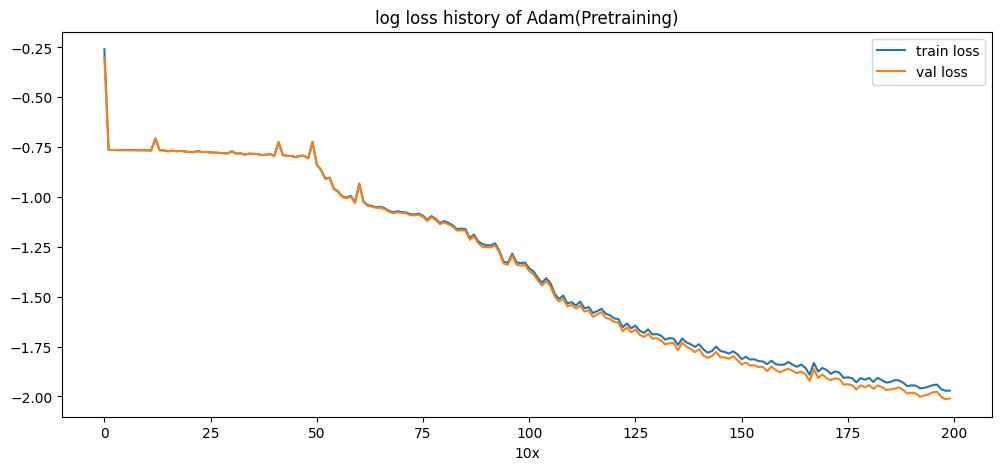

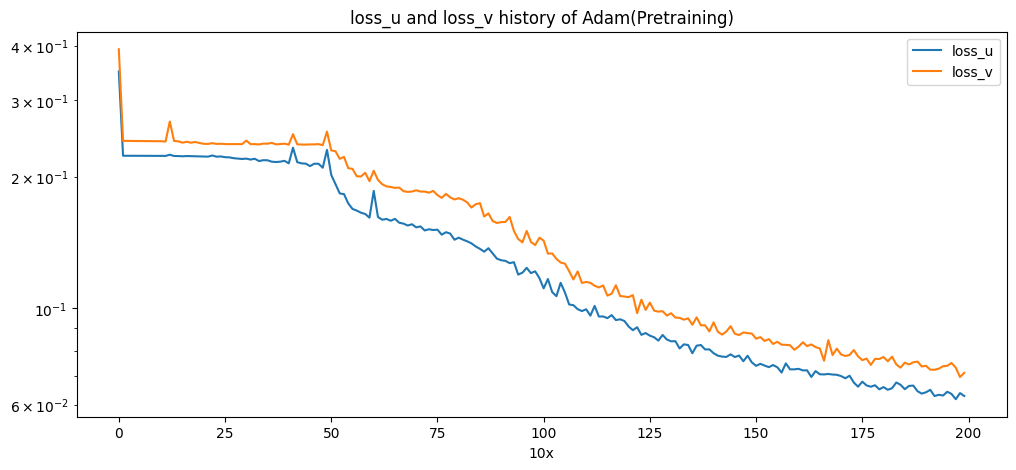

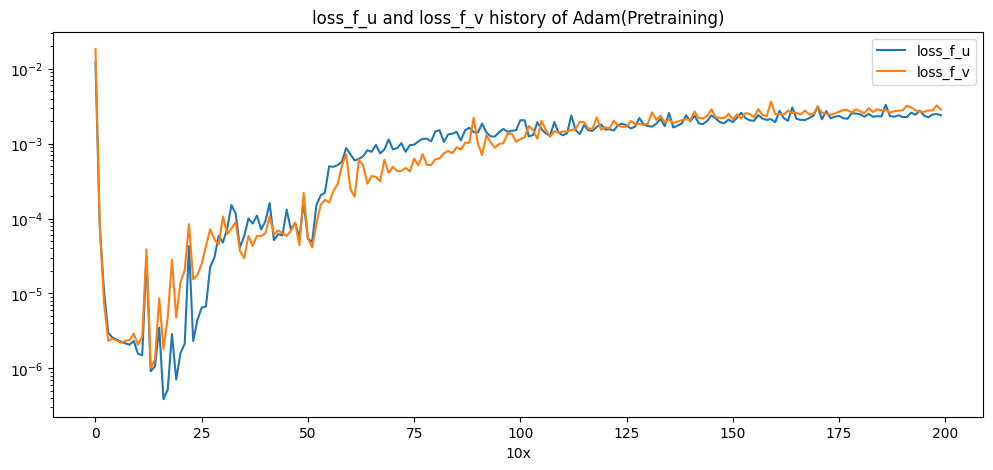

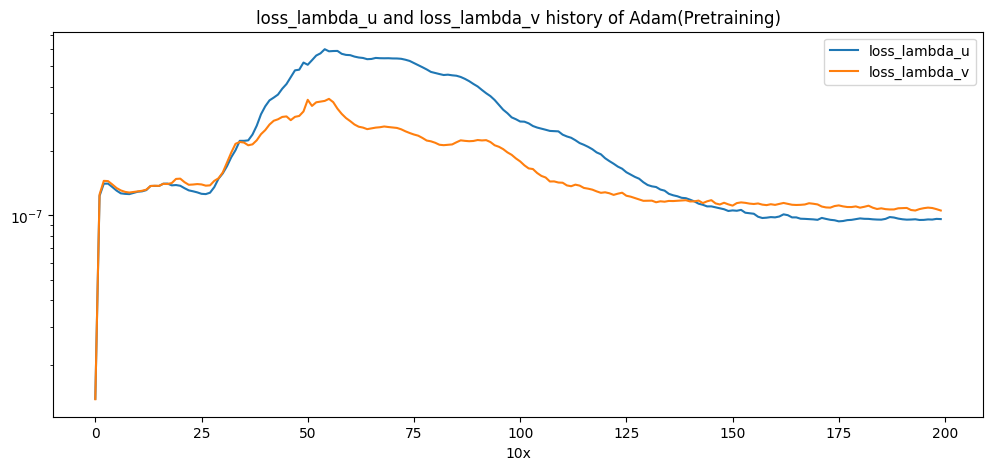

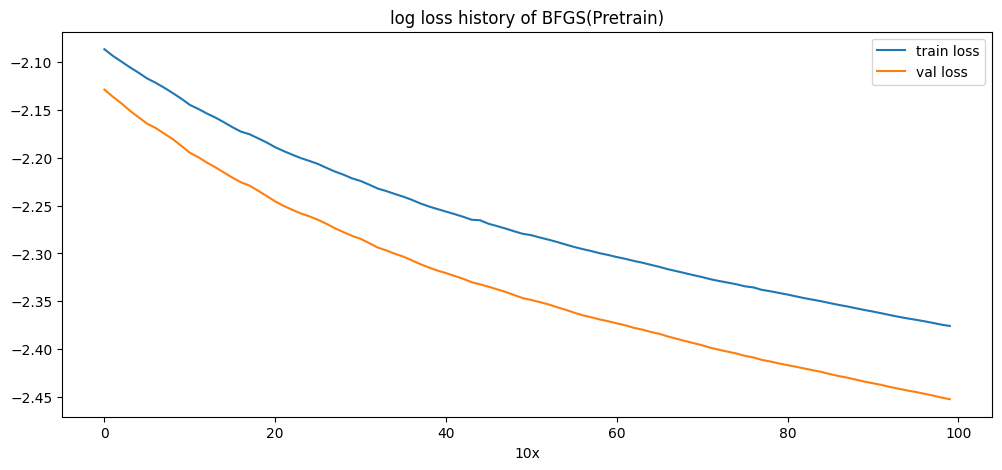

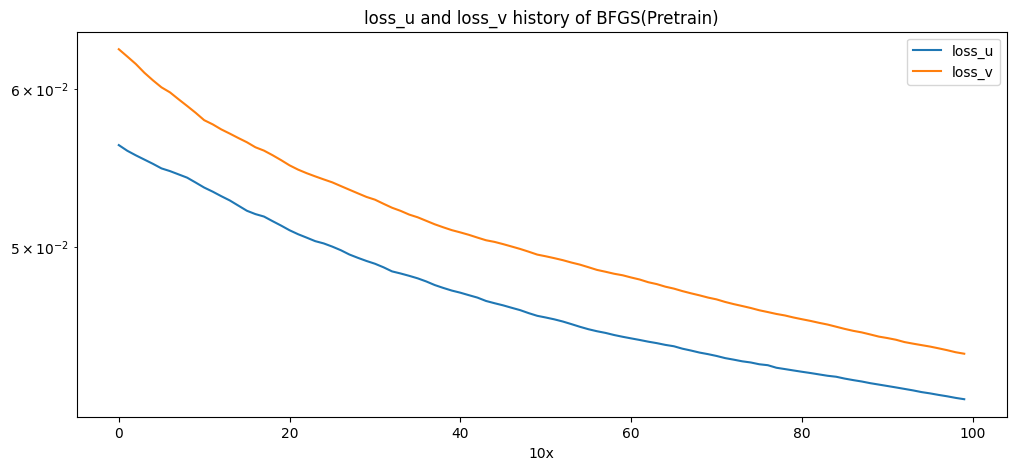

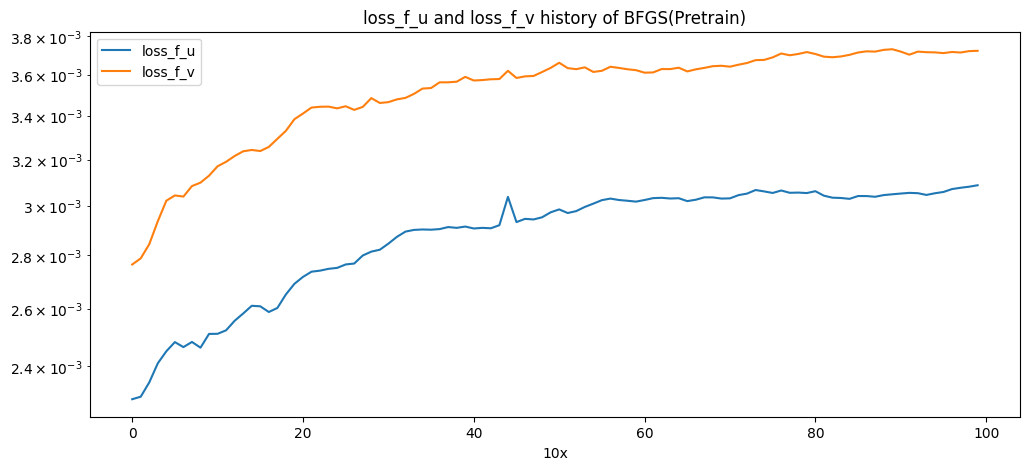

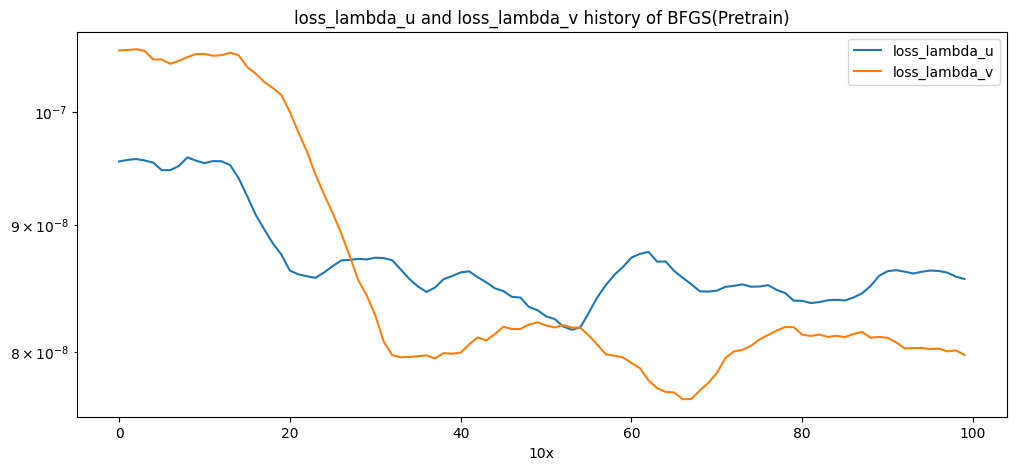

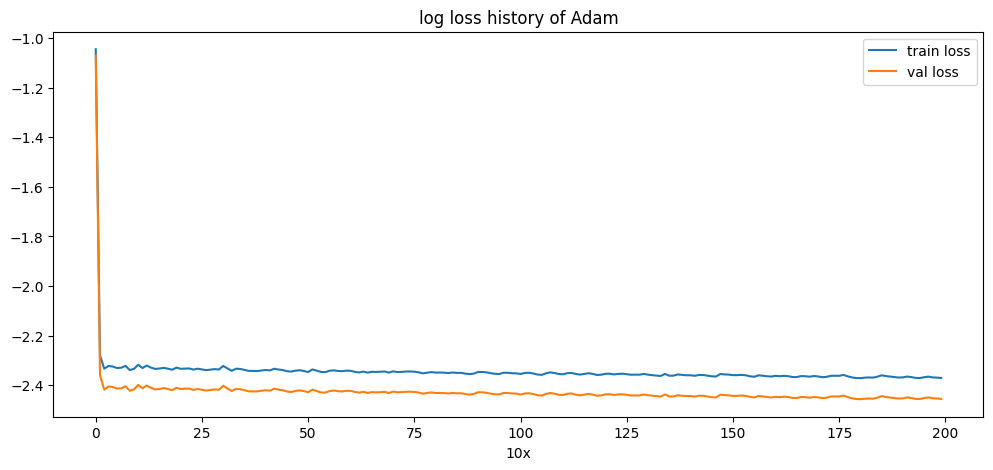

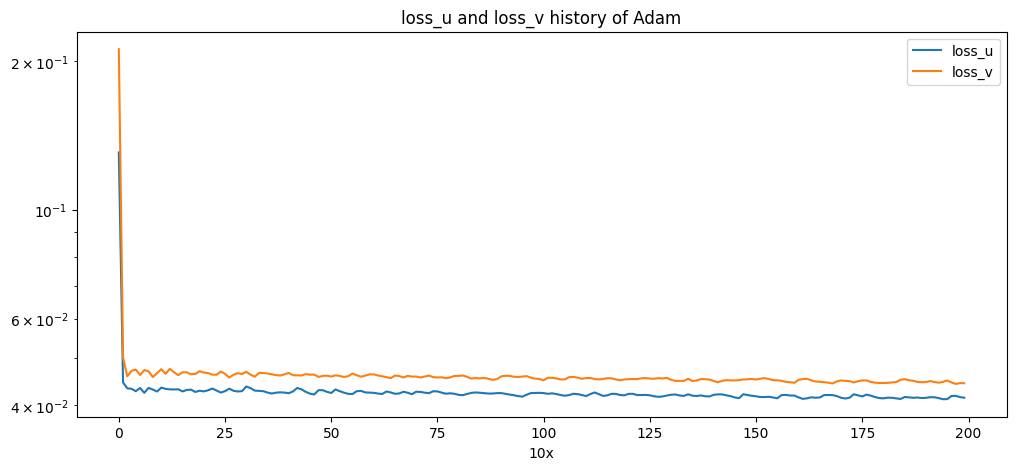

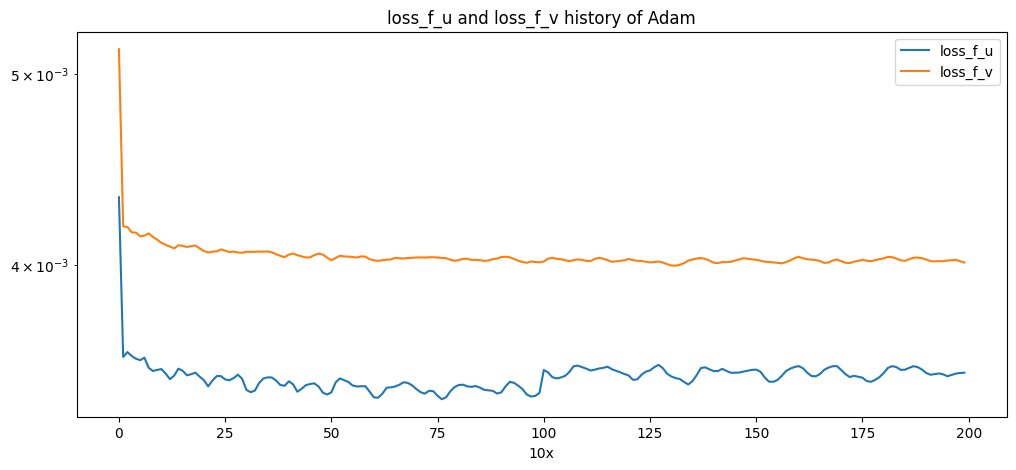

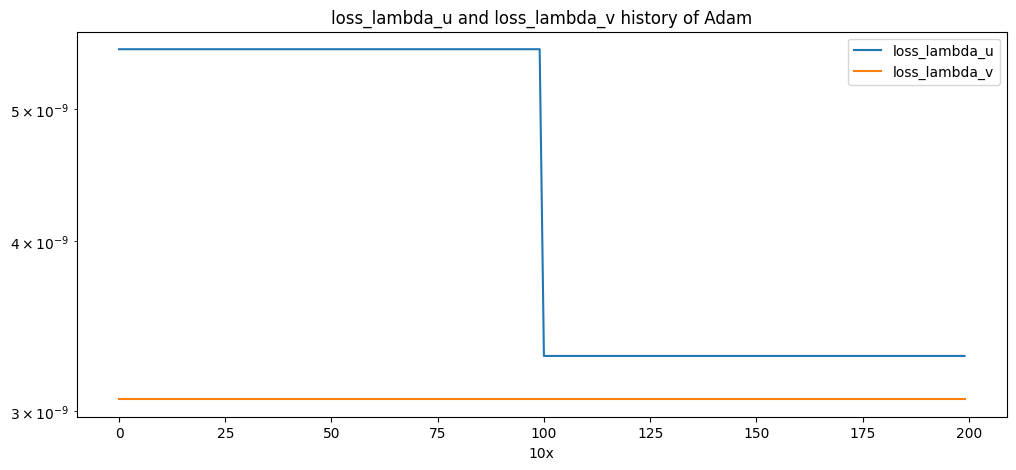

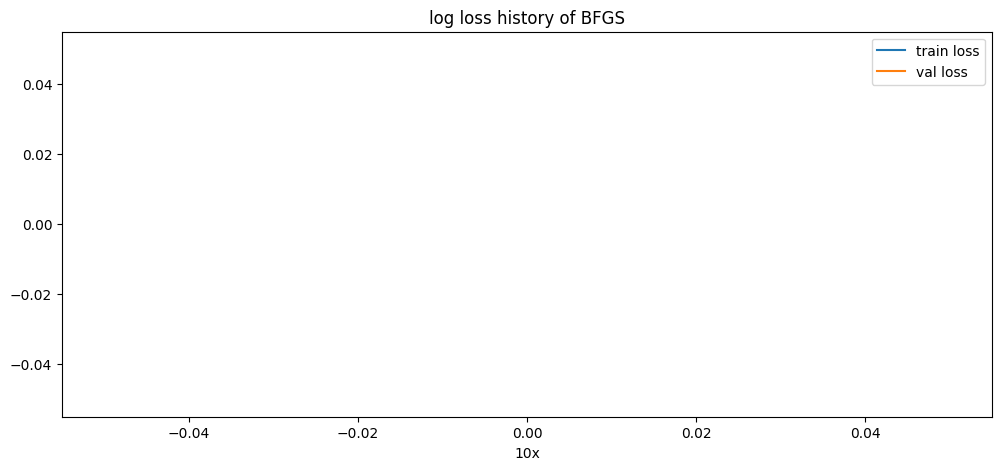

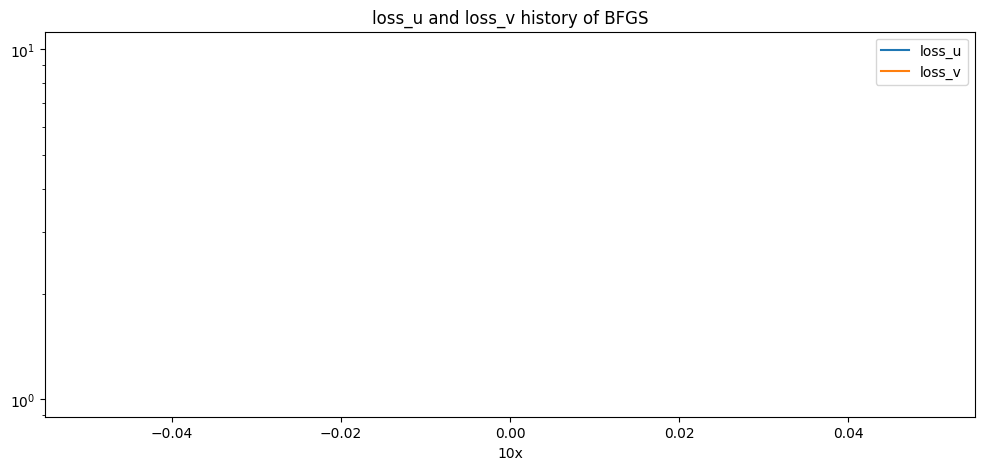

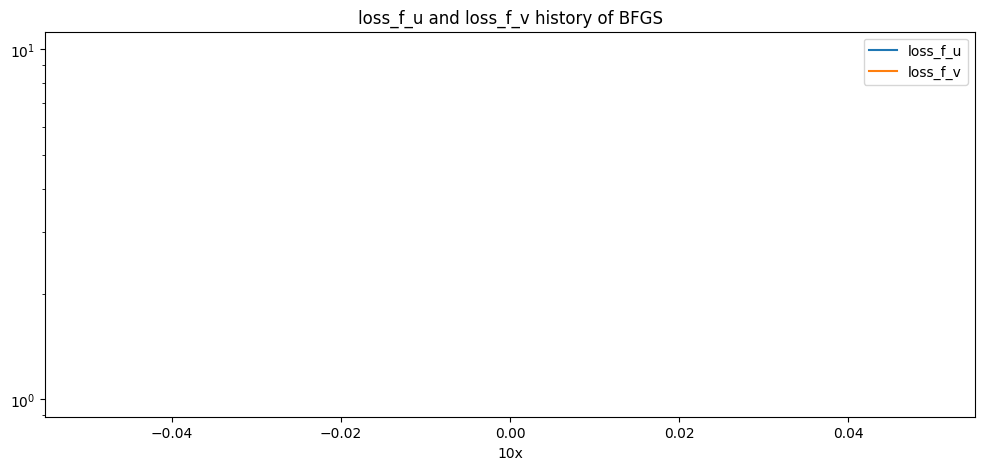

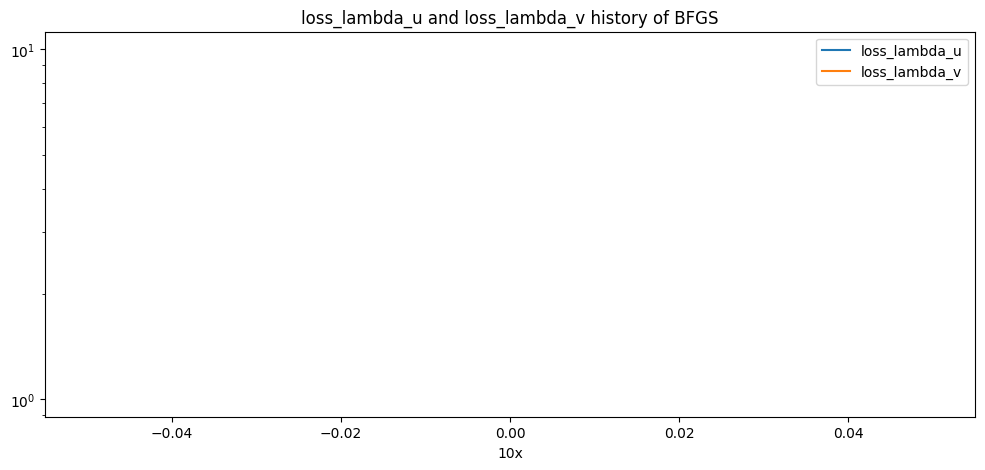

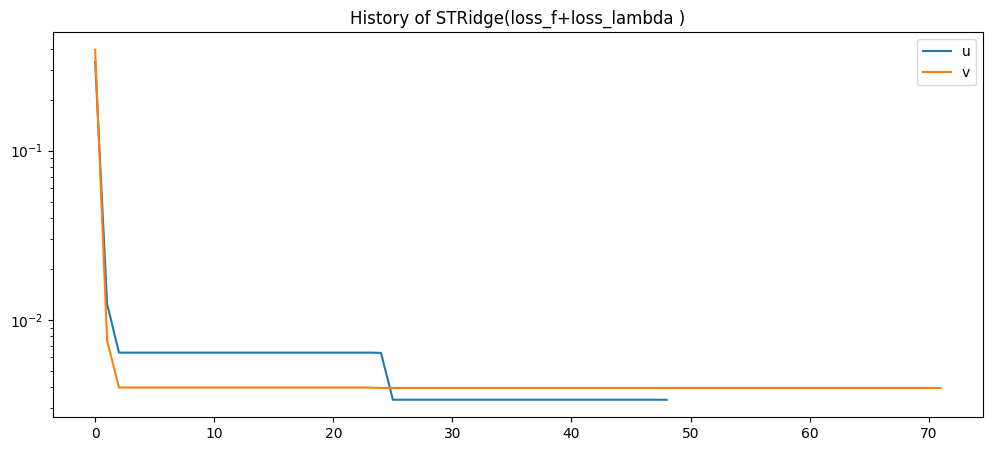

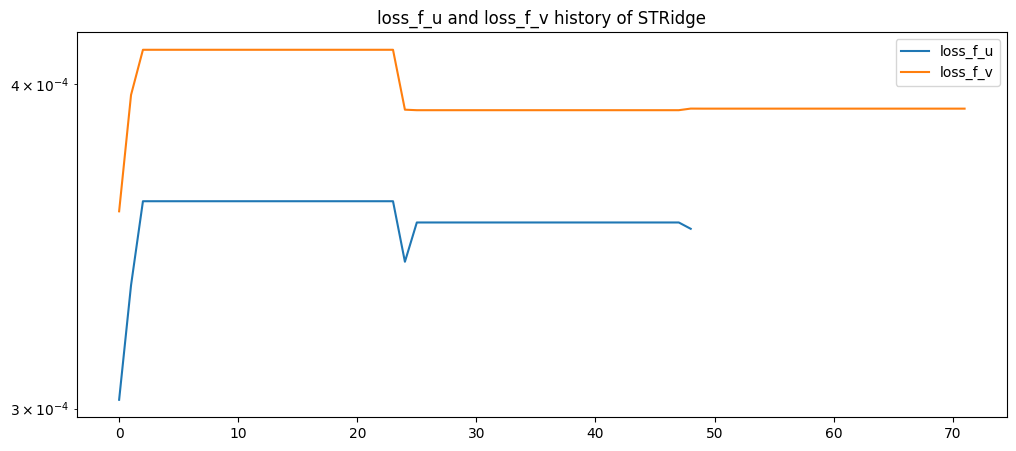

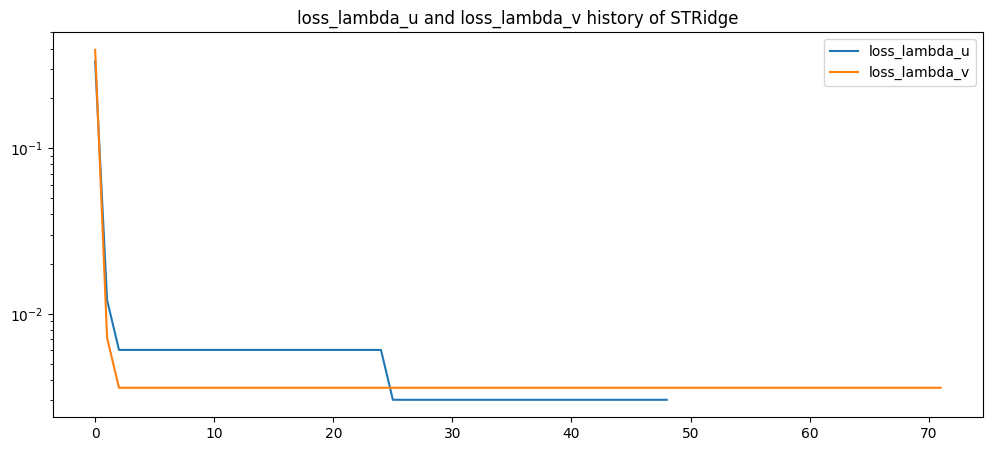

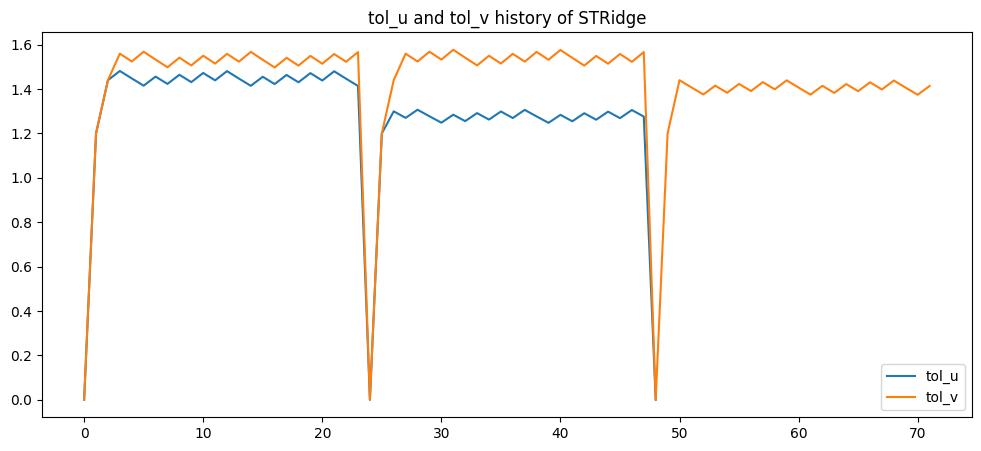

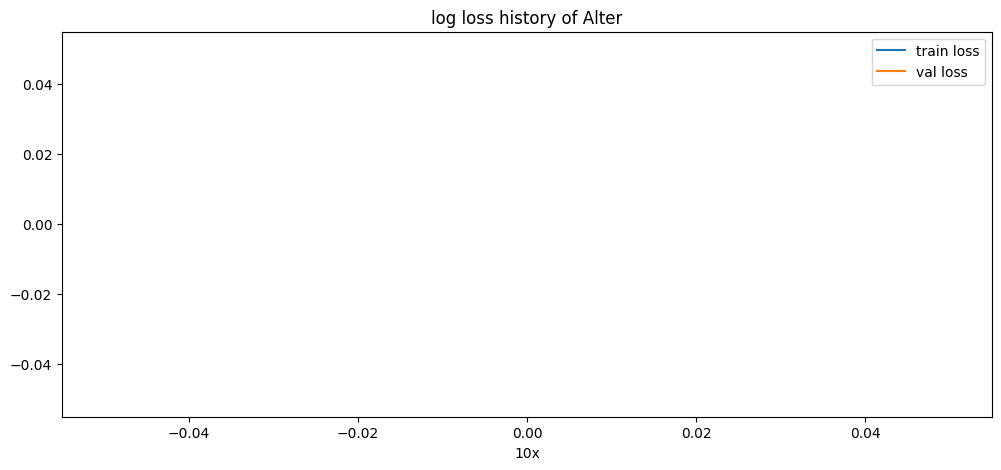

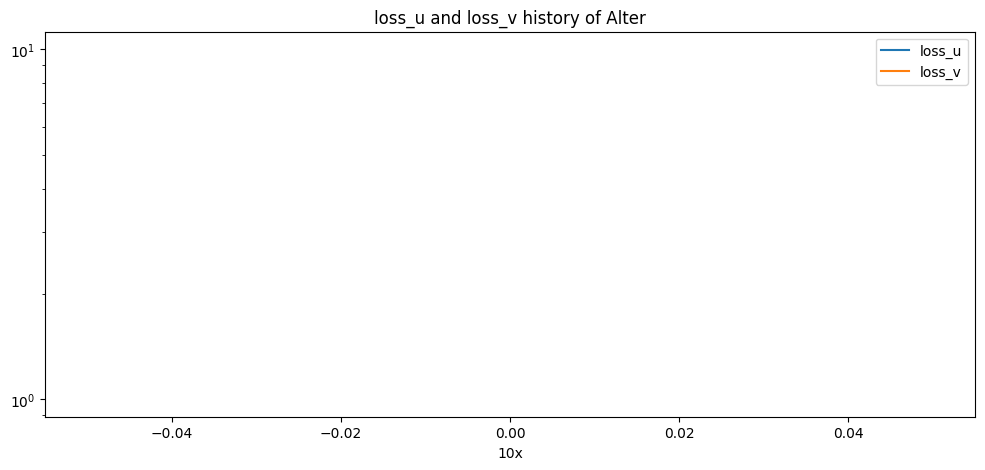

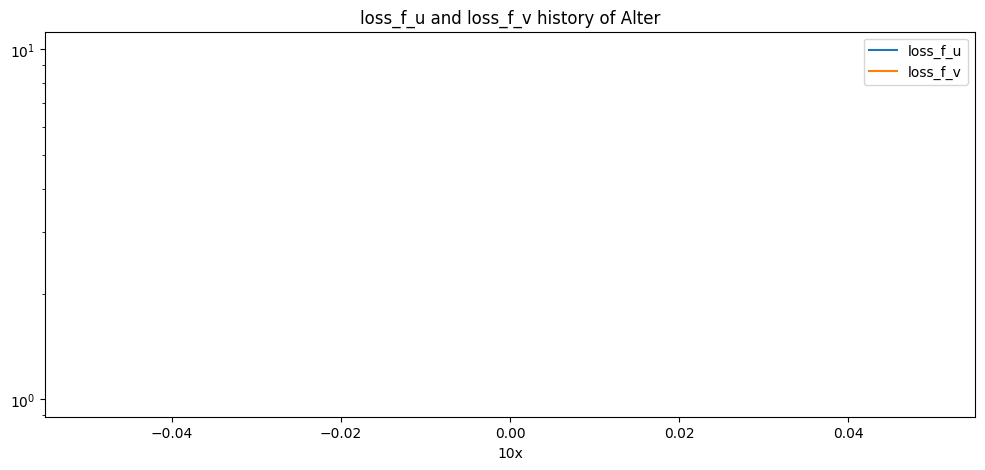

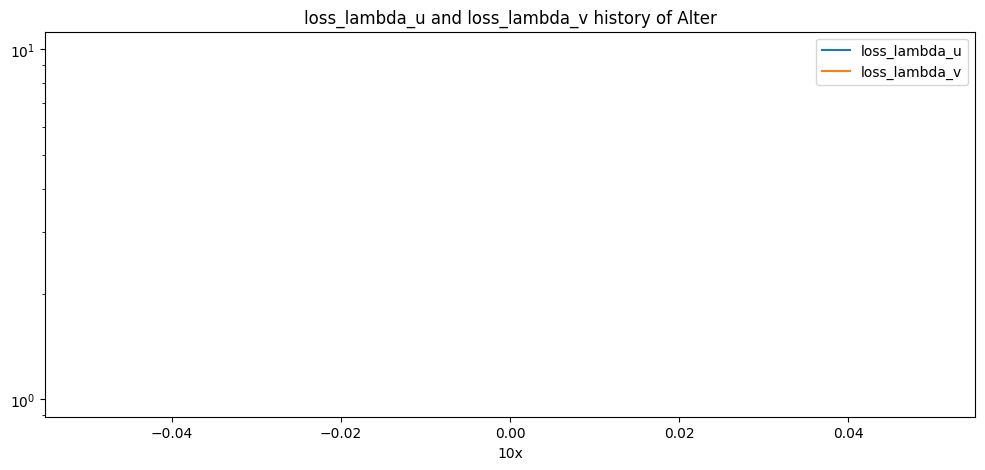

In [5]:
os.environ['CUDA_VISIBLE_DEVICES']='0'

with tf.device('/device:GPU:0'):
    
    # Adam loss history(Pretraining)
    loss_history_Adam_Pretrain = np.empty([0])
    loss_val_history_Adam_Pretrain = np.empty([0])
    loss_u_history_Adam_Pretrain = np.empty([0])
    loss_v_history_Adam_Pretrain = np.empty([0])
    loss_f_u_history_Adam_Pretrain = np.empty([0])
    loss_f_v_history_Adam_Pretrain = np.empty([0])
    loss_lambda_u_history_Adam_Pretrain = np.empty([0])
    loss_lambda_v_history_Adam_Pretrain = np.empty([0])
    lambda_u_history_Adam_Pretrain = np.zeros((110,1))
    lambda_v_history_Adam_Pretrain = np.zeros((110,1))
    
    # L-BFGS-B loss history(Pretraining)
    loss_history_Pretrain = np.empty([0])
    loss_val_history_Pretrain = np.empty([0])
    loss_u_history_Pretrain = np.empty([0])
    loss_v_history_Pretrain = np.empty([0])
    loss_f_u_history_Pretrain = np.empty([0])
    loss_f_v_history_Pretrain = np.empty([0])
    loss_lambda_u_history_Pretrain = np.empty([0])
    loss_lambda_v_history_Pretrain = np.empty([0])
    lambda_u_history_Pretrain = np.zeros((110,1))
    lambda_v_history_Pretrain = np.zeros((110,1))    
    step_Pretrain = 0
    
    # L-BFGS-S loss history
    loss_history = np.empty([0])
    loss_val_history = np.empty([0])
    loss_u_history = np.empty([0])
    loss_v_history = np.empty([0])
    loss_f_u_history = np.empty([0])
    loss_f_v_history = np.empty([0])
    loss_lambda_u_history = np.empty([0])
    loss_lambda_v_history = np.empty([0])
    lambda_u_history = np.zeros((110,1))
    lambda_v_history = np.zeros((110,1))    
    step = 0
    
    # Adam loss history
    loss_history_Adam = np.empty([0])
    loss_val_history_Adam = np.empty([0])
    loss_u_history_Adam = np.empty([0])
    loss_v_history_Adam = np.empty([0])
    loss_f_u_history_Adam = np.empty([0])
    loss_f_v_history_Adam = np.empty([0])
    loss_lambda_u_history_Adam = np.empty([0])
    loss_lambda_v_history_Adam = np.empty([0])
    lambda_u_history_Adam = np.zeros((110,1))
    lambda_v_history_Adam = np.zeros((110,1))
    
    # Alter loss history
    loss_history_Alter = np.empty([0])
    loss_val_history_Alter = np.empty([0])
    loss_u_history_Alter = np.empty([0])
    loss_v_history_Alter = np.empty([0])
    loss_f_u_history_Alter = np.empty([0])
    loss_f_v_history_Alter = np.empty([0])
    loss_lambda_u_history_Alter = np.empty([0])
    loss_lambda_v_history_Alter = np.empty([0])
    lambda_u_history_Alter = np.zeros((110,1))
    lambda_v_history_Alter = np.zeros((110,1))
    
    # STRidge loss histroy
    loss_u_history_STRidge = np.empty([0])
    loss_f_u_history_STRidge = np.empty([0])
    loss_lambda_u_history_STRidge = np.empty([0])
    tol_u_history_STRidge = np.empty([0])
    lambda_u_history_STRidge = np.zeros((110, 1))
    ridge_u_append_counter_STRidge = np.array([0])

    loss_v_history_STRidge = np.empty([0])
    loss_f_v_history_STRidge = np.empty([0])
    loss_lambda_v_history_STRidge = np.empty([0])
    tol_v_history_STRidge = np.empty([0])
    lambda_v_history_STRidge = np.zeros((110, 1))
    ridge_v_append_counter_STRidge = np.array([0])
        
    lib_fun = []
    lib_descr = []
    
    
    np.random.seed(1234)
    tf.set_random_seed(1234)
    
    class PhysicsInformedNN:
# =============================================================================
#     Inspired by Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis.
#     "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems
#     involving nonlinear partial differential equations." Journal of Computational Physics 378 (2019): 686-707.
# =============================================================================
        # Initialize the class
        def __init__(self, X, u, v, X_f, X_val, u_val, v_val, layers, lb, ub, BatchNo):
            
            self.lb = lb.astype(np.float32)
            self.ub = ub.astype(np.float32)
            self.layers = layers
            
            # Initialize NNs
            self.weights, self.biases = self.initialize_NN(layers)
            
            config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
            # config.gpu_options.allow_growth = True
            self.sess = tf.Session(config = config)
            
            # Initialize parameters
            self.lambda_u = tf.Variable(tf.zeros([110, 1], dtype=tf.float32), dtype=tf.float32, name = 'lambda_u')
            self.lambda_v = tf.Variable(tf.zeros([110, 1], dtype=tf.float32), dtype=tf.float32, name = 'lambda_v')
            
            # Specify the list of trainable variables 
            var_list_1 = self.biases + self.weights
            
            var_list_Pretrain = self.biases + self.weights
            var_list_Pretrain.append(self.lambda_u)
            var_list_Pretrain.append(self.lambda_v)
            
            ######### Training data ################
            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]
            self.u = u
            self.v = v
            # Collocation points
            self.x_f = X_f[:,0:1]
            self.y_f = X_f[:,1:2]
            self.t_f = X_f[:,2:3]
            
            self.BatchNo = BatchNo
            self.batchsize_train = np.floor(self.x.shape[0]/self.BatchNo)
            self.batchsize_f = np.floor(self.x_f.shape[0]/self.BatchNo)            
            
            self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
            self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])
            self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
            self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
            self.v_tf = tf.placeholder(tf.float32, shape=[None, self.v.shape[1]])
            self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]], name = 'x_f_tf')
            self.y_f_tf = tf.placeholder(tf.float32, shape=[None, self.y_f.shape[1]])
            self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])
            
            self.u_pred, self.v_pred = self.net_uv(self.x_tf, self.y_tf, self.t_tf)
            self.f_u_pred, self.f_v_pred, self.Phi, self.u_t_pred, self.v_t_pred = self.net_f(self.x_f_tf, self.y_f_tf, self.t_f_tf,
                                                                                              self.batchsize_f)
            
            self.loss_u = tf.reduce_mean(tf.abs(self.u_tf - self.u_pred))   # modified tf.sqare to tf.abs
            self.loss_v = tf.reduce_mean(tf.abs(self.v_tf - self.v_pred))   # modified tf.sqare to tf.abs
            
            self.loss_f_coeff_tf = tf.placeholder(tf.float32)
            
            self.loss_f_u = self.loss_f_coeff_tf*tf.reduce_mean(tf.square(self.f_u_pred))
            self.loss_f_v = self.loss_f_coeff_tf*tf.reduce_mean(tf.square(self.f_v_pred))
            
            self.loss_lambda_u = 1e-7*tf.norm(self.lambda_u, ord=1)    
            self.loss_lambda_v = 1e-7*tf.norm(self.lambda_v, ord=1)    
                        
            self.loss = tf.log(self.loss_u  + self.loss_v + self.loss_f_u + self.loss_f_v + self.loss_lambda_u + self.loss_lambda_v) 
                        
            ######### Validation data ################
            self.x_val = X_val[:,0:1]
            self.y_val = X_val[:,1:2]
            self.t_val = X_val[:,2:3]
            self.u_val = u_val
            self.v_val = v_val
            
            self.batchsize_val = np.floor(self.x_val.shape[0]/self.BatchNo)
            
            self.x_val_tf = tf.placeholder(tf.float32, shape=[None, self.x_val.shape[1]])
            self.y_val_tf = tf.placeholder(tf.float32, shape=[None, self.y_val.shape[1]])
            self.t_val_tf = tf.placeholder(tf.float32, shape=[None, self.t_val.shape[1]])
            self.u_val_tf = tf.placeholder(tf.float32, shape=[None, self.u_val.shape[1]])
            self.v_val_tf = tf.placeholder(tf.float32, shape=[None, self.v_val.shape[1]])
            
            self.u_val_pred, self.v_val_pred = self.net_uv(self.x_val_tf, self.y_val_tf, self.t_val_tf)
    
            self.loss_u_val = tf.reduce_mean(tf.abs(self.u_val_tf - self.u_val_pred))   # modified tf.sqare to tf.abs
            self.loss_v_val = tf.reduce_mean(tf.abs(self.v_val_tf - self.v_val_pred))   # modified tf.sqare to tf.abs
            self.loss_val = tf.log(self.loss_u_val  + self.loss_v_val)     
            
            ######### Optimizor #########################
            self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                    var_list = var_list_1,
                                                                    method = 'L-BFGS-B', 
                                                                    options = {'maxiter': lbfgs_max_iter, #1_000
                                                                               'maxfun': 1_000, 
                                                                               'maxcor': 50,
                                                                               'maxls': 50,
                                                                               'ftol' : 0.1 * np.finfo(float).eps})
    
            self.optimizer_Pretrain = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                            var_list = var_list_Pretrain,
                                                                            method = 'L-BFGS-B', 
                                                                            options = {'maxiter': Pretrain_lbfgs_max_iter, # 40_000
                                                                                       'maxfun': 1000, 
                                                                                       'maxcor': 50,
                                                                                       'maxls': 50,
                                                                                       'ftol' : 0.1 * np.finfo(float).eps})
            
            self.optimizer_Adam = tf.contrib.opt.NadamOptimizer(learning_rate = 1e-3) 
            self.train_op_Adam = self.optimizer_Adam.minimize(self.loss, var_list = var_list_1)
                        
            self.optimizer_Adam_Pretrain = tf.contrib.opt.NadamOptimizer(learning_rate = 3e-3) #5e-3
            self.train_op_Adam_Pretrain = self.optimizer_Adam_Pretrain.minimize(self.loss, var_list = var_list_Pretrain)
                        
            # Save the model after pretraining
            self.saver = tf.train.Saver(var_list_Pretrain)
            
            init = tf.global_variables_initializer()
            self.sess.run(init)
    
        def initialize_NN(self, layers):        
            weights = []
            biases = []
            num_layers = len(layers) 
            for l in range(0,num_layers-1):
                W = self.xavier_init(size=[layers[l], layers[l+1]])
                b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32, name = 'b')
                weights.append(W)
                biases.append(b)        
            return weights, biases
            
        def xavier_init(self, size):
            in_dim = size[0]
            out_dim = size[1]        
            xavier_stddev = np.sqrt(2/(in_dim + out_dim))
            return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32, name = 'W')
        
        def neural_net(self, X, weights, biases):
            num_layers = len(weights) + 1            
            H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
            for l in range(0,num_layers-2):
                W = weights[l]
                b = biases[l]
                H = tf.tanh(tf.add(tf.matmul(H, W), b))
            W = weights[-1]
            b = biases[-1]
            Y = tf.add(tf.matmul(H, W), b)            
            return Y
                     
        def net_uv(self, x, y, t):  
            Y = self.neural_net(tf.concat([x,y,t],1), self.weights, self.biases)
            u = Y[:, 0:1]
            v = Y[:, 1:2]
            return u,v
        
        def net_f(self, x, y, t, N_f):       
            u, v = self.net_uv(x,y,t)
            data = [u,v]            
            
            ## derivatives     
            u_x = tf.gradients(u,x)[0]
            u_xx = tf.gradients(u_x,x)[0]
            u_y = tf.gradients(u,y)[0]
            u_yy = tf.gradients(u_y,y)[0]
            u_xy = tf.gradients(u_x,y)[0]
            u_t = tf.gradients(u,t)[0]
            
            v_x = tf.gradients(v,x)[0]
            v_xx = tf.gradients(v_x,x)[0]
            v_y = tf.gradients(v,y)[0]
            v_yy = tf.gradients(v_y,y)[0]
            v_xy = tf.gradients(v_x,y)[0]
            v_t = tf.gradients(v,t)[0]
            
            derivatives = [1]
            derivatives.append(u_x)
            derivatives.append(u_xx)
            derivatives.append(u_y)
            derivatives.append(u_yy)
            derivatives.append(u_xy)
            derivatives.append(v_x)
            derivatives.append(v_xx)
            derivatives.append(v_y)
            derivatives.append(v_yy)
            derivatives.append(v_xy)
            
            derivatives_description = ['', 'u_{x}', 'u_{xx}', 'u_{y}','u_{yy}','u_{xy}','v_{x}', 'v_{xx}', 'v_{y}','v_{yy}','v_{xy}']
            
            global lib_fun
            global lib_descr
            lib_fun, lib_descr = self.build_library(data, derivatives, derivatives_description, PolyOrder = 3, 
                                                    data_description = ['u','v'])      
            f_u = u_t
            f_v = v_t
            Phi = tf.constant(1, shape=[N_f, 1], dtype=tf.float32)
            for i in range(len(lib_fun)):
                f_u = f_u - lib_fun[i]*self.lambda_u[i:i+1,0:1] # Note that the minus sign instead of the plus sign is uesd here.
                f_v = f_v - lib_fun[i]*self.lambda_v[i:i+1,0:1] # Note that the minus sign instead of the plus sign is uesd here.
                if i != 0:
                    Phi = tf.concat([Phi, lib_fun[i]], 1)
                                                
            return f_u, f_v, Phi, u_t, v_t
        
        def build_library(self, data, derivatives, derivatives_description, PolyOrder, data_description = None):         
            ## polynomial terms
            P = PolyOrder
            lib_poly = [1]
            lib_poly_descr = [''] # it denotes '1'
            for i in range(len(data)): # polynomial terms of univariable
                for j in range(1, P+1):
                    lib_poly.append(data[i]**j)
                    lib_poly_descr.append(data_description[i]+"**"+str(j))
                    
            for i in range(1,P): # polynomial terms of bivariable. Assume we only have 2 variables.
                for j in range(1,P-i+1):
                    lib_poly.append(data[0]**i*data[1]**j)
                    lib_poly_descr.append(data_description[0]+"**"+str(i)+data_description[1]+"**"+str(j))
                    
            ## derivative terms
            lib_deri = derivatives
            lib_deri_descr = derivatives_description
            
            ## Multiplication of derivatives and polynomials (including the multiplication with '1')
            lib_poly_deri = []
            lib_poly_deri_descr = []
            for i in range(len(lib_poly)):
                for j in range(len(lib_deri)):
                    lib_poly_deri.append(lib_poly[i]*lib_deri[j])
                    lib_poly_deri_descr.append(lib_poly_descr[i]+lib_deri_descr[j])
                    
            return lib_poly_deri,lib_poly_deri_descr
                    
        def callback(self, loss, lambda_u, lambda_v, loss_u, loss_v, loss_f_u, loss_f_v, loss_lambda_u, loss_lambda_v, loss_val):
            global step
            step = step+1
            if step%10 == 0:
                #### print out to files
                print('It: %d, log Loss: %e, loss_u: %e, loss_v: %e, loss_f_u: %e, loss_f_v: %e, loss_lambda_u: %e, loss_lambda_v: %e, log loss_val: %e' % 
                      (step, loss, loss_u, loss_v, loss_f_u, loss_f_v, loss_lambda_u, loss_lambda_v, loss_val))
                
                global loss_history
                global loss_val_history
                global lambda_u_history
                global lambda_v_history
                global loss_u_history
                global loss_v_history
                global loss_f_u_history
                global loss_f_v_history
                global loss_lambda_u_history
                global loss_lambda_v_history
                
                loss_history = np.append(loss_history, loss)
                loss_val_history = np.append(loss_val_history, loss_val)
                lambda_u_history = np.append(lambda_u_history, lambda_u, axis=1)
                lambda_v_history = np.append(lambda_v_history, lambda_v, axis=1)
                loss_u_history = np.append(loss_u_history, loss_u)
                loss_v_history = np.append(loss_v_history, loss_v)
                loss_f_u_history = np.append(loss_f_u_history, loss_f_u)
                loss_f_v_history = np.append(loss_f_v_history, loss_f_v)
                loss_lambda_u_history = np.append(loss_lambda_u_history, loss_lambda_u)
                loss_lambda_v_history = np.append(loss_lambda_v_history, loss_lambda_v)
                
        def callback_Pretrain(self, loss, lambda_u, lambda_v, loss_u, loss_v, loss_f_u, loss_f_v, loss_lambda_u, loss_lambda_v,
                              loss_val):
            global step_Pretrain
            step_Pretrain += 1
            if step_Pretrain % 10 == 0:
                #### print out to files
                print('It: %d, log Loss: %e, loss_u: %e, loss_v: %e, loss_f_u: %e, loss_f_v: %e, loss_lambda_u: %e, loss_lambda_v: %e, log loss_val: %e' % 
                      (step_Pretrain, loss, loss_u, loss_v, loss_f_u, loss_f_v, loss_lambda_u, loss_lambda_v, loss_val))
                
                global loss_history_Pretrain
                global loss_val_history_Pretrain
                global lambda_u_history_Pretrain
                global lambda_v_history_Pretrain
                global loss_u_history_Pretrain
                global loss_v_history_Pretrain
                global loss_f_u_history_Pretrain
                global loss_f_v_history_Pretrain
                global loss_lambda_u_history_Pretrain
                global loss_lambda_v_history_Pretrain
                
                loss_history_Pretrain = np.append(loss_history_Pretrain, loss)
                loss_val_history_Pretrain = np.append(loss_val_history_Pretrain, loss_val)
                lambda_u_history_Pretrain = np.append(lambda_u_history_Pretrain, lambda_u, axis=1)
                lambda_v_history_Pretrain = np.append(lambda_v_history_Pretrain, lambda_v, axis=1)
                loss_u_history_Pretrain = np.append(loss_u_history_Pretrain, loss_u)
                loss_v_history_Pretrain = np.append(loss_v_history_Pretrain, loss_v)
                loss_f_u_history_Pretrain = np.append(loss_f_u_history_Pretrain, loss_f_u)
                loss_f_v_history_Pretrain = np.append(loss_f_v_history_Pretrain, loss_f_v)
                loss_lambda_u_history_Pretrain = np.append(loss_lambda_u_history_Pretrain, loss_lambda_u)
                loss_lambda_v_history_Pretrain = np.append(loss_lambda_v_history_Pretrain, loss_lambda_v)
            
        def Pretrain(self):       
            # Dictionary        
                        
            # With batches
            for i in range(self.BatchNo):                
                x_batch = self.x[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
                y_batch = self.y[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
                t_batch = self.t[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
                u_batch = self.u[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
                v_batch = self.v[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
                
                x_f_batch = self.x_f[int(i*self.batchsize_f):int((i+1)*self.batchsize_f), :]
                y_f_batch = self.y_f[int(i*self.batchsize_f):int((i+1)*self.batchsize_f), :]
                t_f_batch = self.t_f[int(i*self.batchsize_f):int((i+1)*self.batchsize_f), :]
                
                x_val_batch = self.x_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
                y_val_batch = self.y_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
                t_val_batch = self.t_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
                u_val_batch = self.u_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
                v_val_batch = self.v_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
                
                self.tf_dict = {self.x_tf: x_batch, self.y_tf: y_batch, self.t_tf: t_batch, self.u_tf: u_batch, self.v_tf: v_batch,
                                self.x_f_tf: x_f_batch, self.y_f_tf: y_f_batch, self.t_f_tf: t_f_batch, 
                                self.x_val_tf: x_val_batch, self.y_val_tf: y_val_batch, self.t_val_tf: t_val_batch,
                                self.u_val_tf: u_val_batch, self.v_val_tf: v_val_batch,
                                self.loss_f_coeff_tf:10}
            
                self.run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
                # Adam optimizer(Pretraining)
                print('Adam(Pretraining) starts')
                start_time = time.time()
                for it_Adam in range(Pre_Adam_iter): #10_000
                    self.sess.run(self.train_op_Adam_Pretrain, self.tf_dict, options=self.run_options)
                    
                    # Print
                    if it_Adam % 10 == 0:
                        elapsed = time.time() - start_time
                        loss, loss_u, loss_v, loss_f_u, loss_f_v, loss_lambda_u, loss_lambda_v, lambda_u, lambda_v, loss_val = \
                            self.sess.run([self.loss, self.loss_u, self.loss_v, self.loss_f_u, self.loss_f_v, self.loss_lambda_u, 
                                           self.loss_lambda_v, self.lambda_u, self.lambda_v, self.loss_val], self.tf_dict)
                        print('It: %d, Log Loss: %e, loss_u: %e, loss_v: %e, loss_f_u: %e, loss_f_v: %e, loss_lambda_u: %e, loss_lambda_v: %e, loss_val: %e, Time: %.2f' 
                              % (it_Adam, loss, loss_u, loss_v, loss_f_u, loss_f_v, loss_lambda_u, 
                              loss_lambda_v, loss_val, elapsed))
                        
                        global loss_history_Adam_Pretrain
                        global loss_val_history_Adam_Pretrain
                        global lambda_u_history_Adam_Pretrain
                        global lambda_v_history_Adam_Pretrain
                        global loss_u_history_Adam_Pretrain
                        global loss_v_history_Adam_Pretrain
                        global loss_f_u_history_Adam_Pretrain
                        global loss_f_v_history_Adam_Pretrain
                        global loss_lambda_u_history_Adam_Pretrain
                        global loss_lambda_v_history_Adam_Pretrain
                        
                        loss_history_Adam_Pretrain = np.append(loss_history_Adam_Pretrain, loss)
                        loss_val_history_Adam_Pretrain = np.append(loss_val_history_Adam_Pretrain, loss_val)
                        lambda_u_history_Adam_Pretrain = np.append(lambda_u_history_Adam_Pretrain, lambda_u, axis=1)
                        lambda_v_history_Adam_Pretrain = np.append(lambda_v_history_Adam_Pretrain, lambda_v, axis=1)
                        loss_u_history_Adam_Pretrain = np.append(loss_u_history_Adam_Pretrain, loss_u)
                        loss_v_history_Adam_Pretrain = np.append(loss_v_history_Adam_Pretrain, loss_v)
                        loss_f_u_history_Adam_Pretrain = np.append(loss_f_u_history_Adam_Pretrain, loss_f_u)
                        loss_f_v_history_Adam_Pretrain = np.append(loss_f_v_history_Adam_Pretrain, loss_f_v)
                        loss_lambda_u_history_Adam_Pretrain = np.append(loss_lambda_u_history_Adam_Pretrain, loss_lambda_u)
                        loss_lambda_v_history_Adam_Pretrain = np.append(loss_lambda_v_history_Adam_Pretrain, loss_lambda_v)
                
                        start_time = time.time()
                                                            
                # L-BFGS-B optimizer(Pretraining)
                print('L-BFGS-B(Pretraining) starts')
                self.optimizer_Pretrain.minimize(self.sess,
                                        feed_dict = self.tf_dict,
                                        fetches = [self.loss, self.lambda_u, self.lambda_v, self.loss_u, self.loss_v, 
                                                   self.loss_f_u, self.loss_f_v, self.loss_lambda_u, self.loss_lambda_v,
                                                   self.loss_val],
                                        loss_callback = self.callback_Pretrain)
                
        def ADO(self, nIter):
            # With batches
            for i in range(self.BatchNo):                
                x_batch = self.x[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
                y_batch = self.y[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
                t_batch = self.t[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
                u_batch = self.u[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
                v_batch = self.v[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
                
                x_f_batch = self.x_f[int(i*self.batchsize_f):int((i+1)*self.batchsize_f), :]
                y_f_batch = self.y_f[int(i*self.batchsize_f):int((i+1)*self.batchsize_f), :]
                t_f_batch = self.t_f[int(i*self.batchsize_f):int((i+1)*self.batchsize_f), :]
                
                x_val_batch = self.x_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
                y_val_batch = self.y_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
                t_val_batch = self.t_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
                u_val_batch = self.u_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
                v_val_batch = self.v_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
                
                self.tf_dict = {self.x_tf: x_batch, self.y_tf: y_batch, self.t_tf: t_batch, self.u_tf: u_batch, self.v_tf: v_batch,
                                self.x_f_tf: x_f_batch, self.y_f_tf: y_f_batch, self.t_f_tf: t_f_batch, 
                                self.x_val_tf: x_val_batch, self.y_val_tf: y_val_batch, self.t_val_tf: t_val_batch,
                                self.u_val_tf: u_val_batch, self.v_val_tf: v_val_batch,
                                self.loss_f_coeff_tf: 10}
                
                self.run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)

                for self.it in range(nIter):    
                    
                    # STRidge optimizer
                    print('STRidge starts')
                    self.callTrainSTRidge()
                    
                    # Adam optimizer                
                    print('Adam starts')
                    start_time = time.time()
                    for it_Adam in range(Adam_iter): #1_000
                        self.sess.run(self.train_op_Adam, self.tf_dict, options=self.run_options)
                        
                        # Print
                        if it_Adam % 10 == 0:
                            elapsed = time.time() - start_time
                            loss, loss_u, loss_v, loss_f_u, loss_f_v, loss_lambda_u, loss_lambda_v, lambda_u, lambda_v, loss_val = \
                                self.sess.run([self.loss, self.loss_u, self.loss_v, self.loss_f_u, self.loss_f_v, self.loss_lambda_u, 
                                               self.loss_lambda_v, self.lambda_u, self.lambda_v, self.loss_val], self.tf_dict)
                            print('It: %d, Log Loss: %e, loss_u: %e, loss_v: %e, loss_f_u: %e, loss_f_v: %e, loss_lambda_u: %e, loss_lambda_v: %e, loss_val: %e, Time: %.2f' 
                                  % (it_Adam, loss, loss_u, loss_v, loss_f_u, loss_f_v, loss_lambda_u, 
                                  loss_lambda_v, loss_val, elapsed))
                            
                            global loss_history_Adam
                            global loss_val_history_Adam
                            global lambda_u_history_Adam
                            global lambda_v_history_Adam
                            global loss_u_history_Adam
                            global loss_v_history_Adam
                            global loss_f_u_history_Adam
                            global loss_f_v_history_Adam
                            global loss_lambda_u_history_Adam
                            global loss_lambda_v_history_Adam
                            
                            loss_history_Adam = np.append(loss_history_Adam, loss)
                            loss_val_history_Adam = np.append(loss_val_history_Adam, loss_val)
                            lambda_u_history_Adam = np.append(lambda_u_history_Adam, lambda_u, axis=1)
                            lambda_v_history_Adam = np.append(lambda_v_history_Adam, lambda_v, axis=1)
                            loss_u_history_Adam = np.append(loss_u_history_Adam, loss_u)
                            loss_v_history_Adam = np.append(loss_v_history_Adam, loss_v)
                            loss_f_u_history_Adam = np.append(loss_f_u_history_Adam, loss_f_u)
                            loss_f_v_history_Adam = np.append(loss_f_v_history_Adam, loss_f_v)
                            loss_lambda_u_history_Adam = np.append(loss_lambda_u_history_Adam, loss_lambda_u)
                            loss_lambda_v_history_Adam = np.append(loss_lambda_v_history_Adam, loss_lambda_v)
                    
                            start_time = time.time()
                            

                # STRidge optimizer
                print('STRidge starts')
                self.callTrainSTRidge()
                
        def predict(self, X_star):
            
            tf_dict = {self.x_tf: X_star[:,0:1], self.y_tf: X_star[:,1:2], self.t_tf: X_star[:,2:3]}
            
            u_star = self.sess.run(self.u_pred, tf_dict)
            v_star = self.sess.run(self.v_pred, tf_dict)
            return u_star, v_star
        
        def callTrainSTRidge(self):
            lam = 1e-5
            d_tol = 1
            maxit = 100
            STR_iters = 10
            
            l0_penalty = None
            
            normalize = 2
            split = 0.8
            print_best_tol = False     
            
            # Process of lambda_u            
            Phi, u_t_pred, v_t_pred = self.sess.run([self.Phi, self.u_t_pred, self.v_t_pred], self.tf_dict)        
            lambda_u2, loss_u_history_STRidge2, loss_f_u_history_STRidge2, loss_lambda_u_history_STRidge2, tol_u_history_STRidge2, \
                optimaltol_u_history2 = self.TrainSTRidge(Phi, u_t_pred, lam, d_tol, maxit, STR_iters, l0_penalty, normalize,
                                                          split, print_best_tol, uv_flag = True)
            self.lambda_u = tf.assign(self.lambda_u, tf.convert_to_tensor(lambda_u2, dtype = tf.float32))
                        
            global loss_u_history_STRidge
            global loss_f_u_history_STRidge
            global loss_lambda_u_history_STRidge
            global tol_u_history_STRidge
            
            loss_u_history_STRidge = np.append(loss_u_history_STRidge, loss_u_history_STRidge2)
            loss_f_u_history_STRidge = np.append(loss_f_u_history_STRidge, loss_f_u_history_STRidge2)
            loss_lambda_u_history_STRidge = np.append(loss_lambda_u_history_STRidge, loss_lambda_u_history_STRidge2)
            tol_u_history_STRidge = np.append(tol_u_history_STRidge, tol_u_history_STRidge2)
            
            # Process of lambda_v    
            lambda_v2, loss_v_history_STRidge2, loss_f_v_history_STRidge2, loss_lambda_v_history_STRidge2, tol_v_history_STRidge2, \
                optimaltol_v_history2 = self.TrainSTRidge(Phi, v_t_pred, lam, d_tol, maxit, STR_iters, l0_penalty, normalize,
                                                          split, print_best_tol, uv_flag = False)
            self.lambda_v = tf.assign(self.lambda_v, tf.convert_to_tensor(lambda_v2, dtype = tf.float32))
                        
            global loss_v_history_STRidge
            global loss_f_v_history_STRidge
            global loss_lambda_v_history_STRidge
            global tol_v_history_STRidge
            
            loss_v_history_STRidge = np.append(loss_v_history_STRidge, loss_v_history_STRidge2)
            loss_f_v_history_STRidge = np.append(loss_f_v_history_STRidge, loss_f_v_history_STRidge2)
            loss_lambda_v_history_STRidge = np.append(loss_lambda_v_history_STRidge, loss_lambda_v_history_STRidge2)
            tol_v_history_STRidge = np.append(tol_v_history_STRidge, tol_v_history_STRidge2)
            
                    
        def TrainSTRidge(self, R, Ut, lam, d_tol, maxit, STR_iters = 10, l0_penalty = None, normalize = 2, split = 0.8, 
                         print_best_tol = False, uv_flag = True):            
# =============================================================================
#        Inspired by Rudy, Samuel H., et al. "Data-driven discovery of partial differential equations."
#        Science Advances 3.4 (2017): e1602614.
# ============================================================================= 
        
            # Split data into 80% training and 20% test, then search for the best tolderance.
            np.random.seed(0) # for consistancy
            n,_ = R.shape
            train = np.random.choice(n, int(n*split), replace = False)
            test = [i for i in np.arange(n) if i not in train]
            TestR = R[test,:]
            TestY = Ut[test,:]
        
            # Set up the initial tolerance and l0 penalty
            d_tol = float(d_tol)
            tol = d_tol
        
            # Get the standard least squares estimator            
            if uv_flag:
                w_best = self.sess.run(self.lambda_u)
            else:
                w_best = self.sess.run(self.lambda_v)
                
            # err_f = np.linalg.norm(TestY - TestR.dot(w_best), 2)
            err_f = np.mean((TestY - TestR.dot(w_best))**2)
            
            if l0_penalty == None and self.it == 0: 
                # l0_penalty = 0.05*np.linalg.cond(R)
                if uv_flag:
                    self.l0_penalty_0_u = 10*err_f
                    l0_penalty = self.l0_penalty_0_u
                else:
                    self.l0_penalty_0_v = 10*err_f
                    l0_penalty = self.l0_penalty_0_v
                    
            elif l0_penalty == None:
                if uv_flag:
                    l0_penalty = self.l0_penalty_0_u
                else:
                    l0_penalty = self.l0_penalty_0_v
            
            err_lambda = l0_penalty*np.count_nonzero(w_best)
            err_best = err_f + err_lambda
            tol_best = 0
                        
            loss_history_STRidge = np.empty([0])
            loss_f_history_STRidge = np.empty([0])
            loss_lambda_history_STRidge = np.empty([0])
            tol_history_STRidge = np.empty([0])
            loss_history_STRidge = np.append(loss_history_STRidge, err_best)
            loss_f_history_STRidge = np.append(loss_f_history_STRidge, err_f)
            loss_lambda_history_STRidge = np.append(loss_lambda_history_STRidge, err_lambda)
            tol_history_STRidge = np.append(tol_history_STRidge, tol_best)
        
            # Now increase tolerance until test performance decreases
            for iter in range(maxit):
        
                # Get a set of coefficients and error
                w = self.STRidge(R,Ut,lam,STR_iters,tol,normalize = normalize, uv_flag = uv_flag)
                # err_f = np.linalg.norm(TestY - TestR.dot(w), 2)
                err_f = np.mean((TestY - TestR.dot(w))**2)
                
                err_lambda = l0_penalty*np.count_nonzero(w)
                err = err_f + err_lambda
        
                # Has the accuracy improved?
                if err <= err_best:
                    err_best = err
                    w_best = w
                    tol_best = tol
                    tol = 1.2*tol
                    
                    loss_history_STRidge = np.append(loss_history_STRidge, err_best)
                    loss_f_history_STRidge = np.append(loss_f_history_STRidge, err_f)
                    loss_lambda_history_STRidge = np.append(loss_lambda_history_STRidge, err_lambda)
                    tol_history_STRidge = np.append(tol_history_STRidge, tol)
        
                else:
                    tol = 0.95*tol # 0.8*tol is the default
        
            if print_best_tol: print ("Optimal tolerance:", tol_best)
            
            optimaltol_history = np.empty([0])
            optimaltol_history = np.append(optimaltol_history, tol_best)
        
            return np.real(w_best), loss_history_STRidge, loss_f_history_STRidge, loss_lambda_history_STRidge, tol_history_STRidge, optimaltol_history
        
        def STRidge(self, X0, y, lam, maxit, tol, normalize = 2, print_results = False, uv_flag = True):                 
            n,d = X0.shape
            X = np.zeros((n,d), dtype=np.complex64)
            # First normalize data
            if normalize != 0:
                Mreg = np.zeros((d,1))
                for i in range(0,d):
                    Mreg[i] = 1.0/(np.linalg.norm(X0[:,i],normalize))
                    X[:,i] = Mreg[i]*X0[:,i]
            else: X = X0
            
            # Get the standard ridge esitmate            
            # Inherit w from previous trainning
            if uv_flag:
                w = self.sess.run(self.lambda_u)/Mreg
            else:
                w = self.sess.run(self.lambda_v)/Mreg
            
            num_relevant = d
            biginds = np.where( abs(w) > tol)[0]
            
            if uv_flag:
                global ridge_u_append_counter_STRidge
                ridge_u_append_counter = 0
                
                global lambda_u_history_STRidge
                lambda_u_history_STRidge = np.append(lambda_u_history_STRidge, np.multiply(Mreg,w), axis = 1)
                ridge_u_append_counter += 1
            else:
                global ridge_v_append_counter_STRidge
                ridge_v_append_counter = 0
                
                global lambda_v_history_STRidge
                lambda_v_history_STRidge = np.append(lambda_v_history_STRidge, np.multiply(Mreg,w), axis = 1)
                ridge_v_append_counter += 1
            
            # Threshold and continue
            for j in range(maxit):
        
                # Figure out which items to cut out
                smallinds = np.where( abs(w) < tol)[0]
                new_biginds = [i for i in range(d) if i not in smallinds]
                    
                # If nothing changes then stop
                if num_relevant == len(new_biginds): break
                else: num_relevant = len(new_biginds)
                    
                # Also make sure we didn't just lose all the coefficients
                if len(new_biginds) == 0:
                    if j == 0: 
                        if normalize != 0: 
                            w = np.multiply(Mreg,w)
                            if uv_flag:
                                lambda_u_history_STRidge = np.append(lambda_u_history_STRidge, w, axis = 1)
                                ridge_u_append_counter += 1
                                ridge_u_append_counter_STRidge = np.append(ridge_u_append_counter_STRidge, ridge_u_append_counter)
                            else:
                                lambda_v_history_STRidge = np.append(lambda_v_history_STRidge, w, axis = 1)
                                ridge_v_append_counter += 1
                                ridge_v_append_counter_STRidge = np.append(ridge_v_append_counter_STRidge, ridge_v_append_counter)
                            return w
                        else: 
                            if uv_flag:
                                lambda_u_history_STRidge = np.append(lambda_u_history_STRidge, w, axis = 1)
                                ridge_u_append_counter += 1
                                ridge_u_append_counter_STRidge = np.append(ridge_u_append_counter_STRidge, ridge_u_append_counter)
                            else:
                                lambda_v_history_STRidge = np.append(lambda_v_history_STRidge, w, axis = 1)
                                ridge_v_append_counter += 1
                                ridge_v_append_counter_STRidge = np.append(ridge_v_append_counter_STRidge, ridge_v_append_counter)
                            return w
                    else: break
                biginds = new_biginds
                
                # Otherwise get a new guess
                w[smallinds] = 0
                
                if lam != 0: 
                    w[biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y))[0]
                    if uv_flag:
                        lambda_u_history_STRidge = np.append(lambda_u_history_STRidge, np.multiply(Mreg,w), axis = 1)
                        ridge_u_append_counter += 1
                    else:
                        lambda_v_history_STRidge = np.append(lambda_v_history_STRidge, np.multiply(Mreg,w), axis = 1)
                        ridge_v_append_counter += 1
                else: 
                    w[biginds] = np.linalg.lstsq(X[:, biginds],y)[0]
                    if uv_flag:
                        lambda_u_history_STRidge = np.append(lambda_u_history_STRidge, np.multiply(Mreg,w), axis = 1)
                        ridge_u_append_counter += 1
                    else:
                        lambda_v_history_STRidge = np.append(lambda_v_history_STRidge, np.multiply(Mreg,w), axis = 1)
                        ridge_v_append_counter += 1
    
            # Now that we have the sparsity pattern, use standard least squares to get w
            if biginds != []: 
                w[biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y))[0]
            
            if normalize != 0: 
                w = np.multiply(Mreg,w)
                if uv_flag:
                    lambda_u_history_STRidge = np.append(lambda_u_history_STRidge, w, axis = 1)
                    ridge_u_append_counter += 1
                    ridge_u_append_counter_STRidge = np.append(ridge_u_append_counter_STRidge, ridge_u_append_counter)
                else:
                    lambda_v_history_STRidge = np.append(lambda_v_history_STRidge, w, axis = 1)
                    ridge_v_append_counter += 1
                    ridge_v_append_counter_STRidge = np.append(ridge_v_append_counter_STRidge, ridge_v_append_counter)
                return w
            else:
                if uv_flag:
                    lambda_u_history_STRidge = np.append(lambda_u_history_STRidge, w, axis = 1)
                    ridge_u_append_counter += 1
                    ridge_u_append_counter_STRidge = np.append(ridge_u_append_counter_STRidge, ridge_u_append_counter)
                else:
                    lambda_v_history_STRidge = np.append(lambda_v_history_STRidge, w, axis = 1)
                    ridge_v_append_counter += 1
                    ridge_v_append_counter_STRidge = np.append(ridge_v_append_counter_STRidge, ridge_v_append_counter)
                return w
    def preprocess_test(filename):
        data = np.load(filename)

        t = data[:, 2].flatten()[:,None]/24
        x = data[:, 0].flatten()[:,None]
        y = data[:, 1].flatten()[:,None]
        u = data[:, 3].flatten()[:,None]
        v = data[:, 4].flatten()[:,None]     


        X_star = np.hstack((x, y, t))
        u_star = u
        v_star = v

        # Doman bounds
        lb = X_star.min(0)
        ub = X_star.max(0)    


        # Select some points as training/val data
        N_uv_s = max(X_star.shape[0], 5000*15)  #2500*15 #the number 15 here is a reference to the number of time steps in the original code. 12_000_000 is roughly the max number of points to avoid OOM error
        print(f"N_uv_s: {N_uv_s}")
        idx = np.random.choice(X_star.shape[0], N_uv_s, replace=False)

        X_star_meas = X_star[idx, :]
        u_star_meas = u_star[idx, :]
        v_star_meas = v_star[idx, :]


        # Training measurements, which are randomly sampled spatio-temporally
        Split_TrainVal = 0.8
        N_u_train = int(X_star_meas.shape[0]*Split_TrainVal)
        idx_train = np.random.choice(X_star_meas.shape[0], N_u_train, replace=False)


        X_star_train = X_star_meas[idx_train,:]
        u_star_train = u_star_meas[idx_train,:]
        v_star_train = v_star_meas[idx_train,:]

        # Validation Measurements, which are the rest of measurements
        idx_val = np.setdiff1d(np.arange(X_star_meas.shape[0]), idx_train, assume_unique=True)

        X_star_val = X_star_meas[idx_val,:]
        u_star_val = u_star_meas[idx_val,:]
        v_star_val = v_star_meas[idx_val,:]







        # Collocation points
        N_f = 80000
        X_f = lb + (ub-lb)*lhs(3, N_f)


        BatchNo = 1

        X_star_train = X_star_train.astype(np.float32)
        u_star_train = u_star_train.astype(np.float32)
        v_star_train = v_star_train.astype(np.float32)
        X_f = X_f.astype(np.float32)
        X_star_val = X_star_val.astype(np.float32)
        u_star_val = u_star_val.astype(np.float32)
        v_star_val = v_star_val.astype(np.float32)



        return X_star, X_star_train, u_star_train, v_star_train, X_star_val, u_star_val, v_star_val, X_f, lb, ub
        
    if __name__ == "__main__": 
         
        start_time = time.time()
        
        layers = [3] + 8*[60] + [2]

        
        X_star, X_star_train, u_star_train, v_star_train, X_star_val, u_star_val, v_star_val, X_f, lb, ub = preprocess_test(data_file)
        BatchNo = 1 
# =============================================================================
#         train model
# =============================================================================
        model = PhysicsInformedNN(X_star_train, u_star_train, v_star_train, X_f, X_star_val, u_star_val, v_star_val, layers, lb, ub, BatchNo)
        model.Pretrain()
        
        # Checkpoint model        
        saved_path = model.saver.save(model.sess, data_out_folder + '/saved_variable')
        # print('model saved in {}'.format(saved_path))                
        
        ## Restore pretrained model
#        # in case we need to create graph 
        # model = PhysicsInformedNN(X_star_train, u_star_train, v_star_train, X_f, X_star_val, u_star_val, v_star_val, layers, lb, ub, BatchNo)
#        # restore the saved vairable
        # model.saver.restore(model.sess, data_out_folder + '/saved_variable')
        
        model.ADO(ADO_CYCLES)
        
        saved_path = model.saver.save(model.sess, data_out_folder + '/saved_variable_ADO')
        # model.saver.restore(model.sess, data_out_folder + '/saved_variable_ADO')
# =============================================================================
#         check if training efforts are sufficient
# =============================================================================
        elapsed = time.time() - start_time   
        f = open(data_out_folder + "/stdout.txt", "w")                         
        f.write('Training time: %.4f \n' % (elapsed))
        
        u_train_pred, v_train_pred = model.predict(X_star_train)
        error_u_train = np.linalg.norm(u_star_train-u_train_pred,2)/np.linalg.norm(u_star_train,2)        
        error_v_train = np.linalg.norm(v_star_train-v_train_pred,2)/np.linalg.norm(v_star_train,2)
        f.write('Training Error u: %e \n' % (error_u_train))    
        f.write('Training Error v: %e \n' % (error_v_train))   
        
        u_val_pred, v_val_pred = model.predict(X_star_val)
        error_u_val = np.linalg.norm(u_star_val-u_val_pred,2)/np.linalg.norm(u_star_val,2)        
        error_v_val = np.linalg.norm(v_star_val-v_val_pred,2)/np.linalg.norm(v_star_val,2)
        f.write('Val Error u: %e \n' % (error_u_val))    
        f.write('Val Error v: %e \n' % (error_v_val))   
        
        ######################## Plots for Adam(Pretraining) #################
        fig = plt.figure()
        plt.plot(loss_history_Adam_Pretrain)
        plt.plot(loss_val_history_Adam_Pretrain)
        plt.legend(('train loss', 'val loss'))
        plt.xlabel('10x')
        plt.title('log loss history of Adam(Pretraining)')
        plt.savefig(images_out_folder + '/1.png')
        
        fig = plt.figure()
        plt.plot(loss_u_history_Adam_Pretrain)
        plt.plot(loss_v_history_Adam_Pretrain)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_u', 'loss_v'))
        plt.title('loss_u and loss_v history of Adam(Pretraining)')  
        plt.savefig(images_out_folder + '/2.png')
        
        fig = plt.figure()
        plt.plot(loss_f_u_history_Adam_Pretrain)
        plt.plot(loss_f_v_history_Adam_Pretrain)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_f_u', 'loss_f_v'))
        plt.title('loss_f_u and loss_f_v history of Adam(Pretraining)')  
        plt.savefig(images_out_folder + '/3.png')
                
        fig = plt.figure()
        plt.plot(loss_lambda_u_history_Adam_Pretrain)
        plt.plot(loss_lambda_v_history_Adam_Pretrain)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_lambda_u', 'loss_lambda_v'))
        plt.title('loss_lambda_u and loss_lambda_v history of Adam(Pretraining)')  
        plt.savefig(images_out_folder + '/4.png')
        
        ######################## Plots for L-BFGS-B(Pretraining) #################
        fig = plt.figure()
        plt.plot(loss_history_Pretrain)
        plt.plot(loss_val_history_Pretrain)
        plt.legend(('train loss', 'val loss'))
        plt.xlabel('10x')
        plt.title('log loss history of BFGS(Pretrain)')  
        plt.savefig(images_out_folder + '/5.png')
        
        fig = plt.figure()
        plt.plot(loss_u_history_Pretrain)
        plt.plot(loss_v_history_Pretrain)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_u', 'loss_v'))
        plt.title('loss_u and loss_v history of BFGS(Pretrain)')  
        plt.savefig(images_out_folder + '/6.png')
        
        fig = plt.figure()
        plt.plot(loss_f_u_history_Pretrain)
        plt.plot(loss_f_v_history_Pretrain)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_f_u', 'loss_f_v'))
        plt.title('loss_f_u and loss_f_v history of BFGS(Pretrain)')     
        plt.savefig(images_out_folder + '/7.png')
        
        fig = plt.figure()
        plt.plot(loss_lambda_u_history_Pretrain)
        plt.plot(loss_lambda_v_history_Pretrain)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_lambda_u', 'loss_lambda_v'))
        plt.title('loss_lambda_u and loss_lambda_v history of BFGS(Pretrain)') 
        plt.savefig(images_out_folder + '/8.png')
    
        ######################## Plots for Adam #################
        fig = plt.figure()
        plt.plot(loss_history_Adam)
        plt.plot(loss_val_history_Adam)
        plt.legend(('train loss', 'val loss'))
        plt.xlabel('10x')
        plt.title('log loss history of Adam')
        plt.savefig(images_out_folder + '/9.png')
        
        fig = plt.figure()
        plt.plot(loss_u_history_Adam)
        plt.plot(loss_v_history_Adam)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_u', 'loss_v'))
        plt.title('loss_u and loss_v history of Adam')  
        plt.savefig(images_out_folder + '/10.png')
        
        fig = plt.figure()
        plt.plot(loss_f_u_history_Adam)
        plt.plot(loss_f_v_history_Adam)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_f_u', 'loss_f_v'))
        plt.title('loss_f_u and loss_f_v history of Adam') 
        plt.savefig(images_out_folder + '/11.png')
                
        fig = plt.figure()
        plt.plot(loss_lambda_u_history_Adam)
        plt.plot(loss_lambda_v_history_Adam)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_lambda_u', 'loss_lambda_v'))
        plt.title('loss_lambda_u and loss_lambda_v history of Adam')  
        plt.savefig(images_out_folder + '/12.png')
                
        ######################## Plots for BFGS #################
        fig = plt.figure()
        plt.plot(loss_history)
        plt.plot(loss_val_history)
        plt.legend(('train loss', 'val loss'))
        plt.xlabel('10x')
        plt.title('log loss history of BFGS')  
        plt.savefig(images_out_folder + '/13.png')
        
        fig = plt.figure()
        plt.plot(loss_u_history)
        plt.plot(loss_v_history)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_u', 'loss_v'))
        plt.title('loss_u and loss_v history of BFGS')  
        plt.savefig(images_out_folder + '/14.png')
        
        fig = plt.figure()
        plt.plot(loss_f_u_history)
        plt.plot(loss_f_v_history)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_f_u', 'loss_f_v'))
        plt.title('loss_f_u and loss_f_v history of BFGS')     
        plt.savefig(images_out_folder + '/15.png')
        
        fig = plt.figure()
        plt.plot(loss_lambda_u_history)
        plt.plot(loss_lambda_v_history)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_lambda_u', 'loss_lambda_v'))
        plt.title('loss_lambda_u and loss_lambda_v history of BFGS')  
        plt.savefig(images_out_folder + '/16.png')
        
        ######################## Plots for STRidge #################        
        fig = plt.figure()
        plt.plot(loss_u_history_STRidge)
        plt.plot(loss_v_history_STRidge)
        plt.yscale('log')       
        plt.legend(('u', 'v'))
        plt.title('History of STRidge(loss_f+loss_lambda )')  
        plt.savefig(images_out_folder + '/17.png')
        
        fig = plt.figure()
        plt.plot(loss_f_u_history_STRidge)
        plt.plot(loss_f_v_history_STRidge)
        plt.yscale('log')       
        plt.legend(('loss_f_u', 'loss_f_v'))
        plt.title('loss_f_u and loss_f_v history of STRidge') 
        plt.savefig(images_out_folder + '/18.png')
        
        fig = plt.figure()
        plt.plot(loss_lambda_u_history_STRidge)
        plt.plot(loss_lambda_v_history_STRidge)
        plt.yscale('log')      
        plt.legend(('loss_lambda_u', 'loss_lambda_v'))
        plt.title('loss_lambda_u and loss_lambda_v history of STRidge')  
        plt.savefig(images_out_folder + '/19.png')
        
        fig = plt.figure()
        plt.plot(tol_u_history_STRidge)
        plt.plot(tol_v_history_STRidge)
        plt.legend(('tol_u', 'tol_v'))
        plt.title('tol_u and tol_v history of STRidge')  
        plt.savefig(images_out_folder + '/20.png')
        
        ######################## Plots for Alter #################
        fig = plt.figure()
        plt.plot(loss_history_Alter)
        plt.plot(loss_val_history_Alter)
        plt.legend(('train loss', 'val loss'))
        plt.xlabel('10x')
        plt.title('log loss history of Alter')
        plt.savefig(images_out_folder + '/21.png')
        
        fig = plt.figure()
        plt.plot(loss_u_history_Alter)
        plt.plot(loss_v_history_Alter)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_u', 'loss_v'))
        plt.title('loss_u and loss_v history of Alter')  
        plt.savefig(images_out_folder + '/22.png')
        
        fig = plt.figure()
        plt.plot(loss_f_u_history_Alter)
        plt.plot(loss_f_v_history_Alter)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_f_u', 'loss_f_v'))
        plt.title('loss_f_u and loss_f_v history of Alter') 
        plt.savefig(images_out_folder + '/23.png')
                
        fig = plt.figure()
        plt.plot(loss_lambda_u_history_Alter)
        plt.plot(loss_lambda_v_history_Alter)
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.legend(('loss_lambda_u', 'loss_lambda_v'))
        plt.title('loss_lambda_u and loss_lambda_v history of Alter')  
        plt.savefig(images_out_folder + '/24.png')
        
# =============================================================================
#       Compare with ground truth if training efforts are sufficient      
# =============================================================================
#         # u
#         lambda_u_value = model.sess.run(model.lambda_u)        
#         lambda_u_true = np.zeros((110,1))
#         lambda_u_true[2] = -0.1 # -0.1*u_xx
#         lambda_u_true[4] = -0.1 # -0.1*u_yy
#         lambda_u_true[11] = -1 # -u   
#         lambda_u_true[33] = 1 # u^3
#         lambda_u_true[66] = -1 # -v^3
#         lambda_u_true[88] = 1 # u*v^2
#         lambda_u_true[99] = -1 # -u^2*v
#         lambda_u_true = -lambda_u_true # Note that there's a negative sign due to the different calculation in net_f.
#         cosine_similarity_u = 1-distance.cosine(lambda_u_true,lambda_u_value)
#         f.write('\nCosine similarity of lambda_u: %.2f \n' % (cosine_similarity_u))
#         error_lambda_u = np.linalg.norm(lambda_u_true-lambda_u_value,2)/np.linalg.norm(lambda_u_true,2)
#         f.write('lambda_u Error: %.2f \n' % (error_lambda_u))
#         nonzero_ind_u = np.nonzero(lambda_u_true)
#         lambda_u_error_vector = np.absolute((lambda_u_true[nonzero_ind_u]-lambda_u_value[nonzero_ind_u])/lambda_u_true[nonzero_ind_u])
#         error_lambda_u_mean = np.mean(lambda_u_error_vector)
#         error_lambda_u_std = np.std(lambda_u_error_vector)
#         f.write('lambda_u Mean Error: %.4f \n' % (error_lambda_u_mean))
#         f.write('lambda_u Std Error: %.4f \n' % (error_lambda_u_std))
        
#         disc_eq_temp = []
#         for i_lib in range(len(lib_descr)):
#             if lambda_u_value[i_lib] != 0:
#                 disc_eq_temp.append(str(lambda_u_value[i_lib,0]) + lib_descr[i_lib])
#         disc_eq_u = '+'.join(disc_eq_temp)        
#         f.write('The discovered equation: u_t = ' + disc_eq_u)
    
        # v
#         lambda_v_value = model.sess.run(model.lambda_v)
#         lambda_v_true = np.zeros((110,1))
#         lambda_v_true[7] = -0.1 # -0.1*v_xx
#         lambda_v_true[9] = -0.1 # -0.1*v_yy
#         lambda_v_true[33] = 1 # u^3
#         lambda_v_true[44] = -1 # -v
#         lambda_v_true[66] = 1 # v^3
#         lambda_v_true[88] = 1 # u*v^2
#         lambda_v_true[99] = 1 # u^2*v      
#         lambda_v_true = -lambda_v_true # Note that there's a negative sign due to the different calculation in net_f.
#         cosine_similarity_v = 1-distance.cosine(lambda_v_true,lambda_v_value)
#         f.write('Cosine similarity of lambda_v: %.2f \n' % (cosine_similarity_v))
#         error_lambda_v = np.linalg.norm(lambda_v_true-lambda_v_value,2)/np.linalg.norm(lambda_v_true,2)
#         f.write('lambda_v Error: %.2f \n' % (error_lambda_v))
#         nonzero_ind_v = np.nonzero(lambda_v_true)
#         lambda_v_error_vector = np.absolute((lambda_v_true[nonzero_ind_v]-lambda_v_value[nonzero_ind_v])/lambda_v_true[nonzero_ind_v])
#         error_lambda_v_mean = np.mean(lambda_v_error_vector)
#         error_lambda_v_std = np.std(lambda_v_error_vector)
#         f.write('lambda_v Mean Error: %.4f \n' % (error_lambda_v_mean))
#         f.write('lambda_v Std Error: %.4f \n' % (error_lambda_v_std))
        
#         lambda_total_error_vector = np.concatenate((lambda_u_error_vector, lambda_v_error_vector))
#         error_lambda_total_mean = np.mean(lambda_total_error_vector)
#         error_lambda_total_std = np.std(lambda_total_error_vector)
#         f.write('lambda_total Mean Error: %.4f \n' % (error_lambda_total_mean))
#         f.write('lambda_total Std Error: %.4f \n' % (error_lambda_total_std))
        
#         disc_eq_temp = []
#         for i_lib in range(len(lib_descr)):
#             if lambda_v_value[i_lib] != 0:
#                 disc_eq_temp.append(str(lambda_v_value[i_lib,0]) + lib_descr[i_lib])
#         disc_eq_v = '+'.join(disc_eq_temp)        
#         f.write('The discovered equation: v_t = ' + disc_eq_v)
        
#         scipy.io.savemat(data_out_folder + '/DiscLam_ADO.mat', {'Lamu_True': lambda_u_true, 'Lamu_Disc': lambda_u_value,
#                                          'Lamv_True': lambda_v_true, 'Lamv_Disc': lambda_v_value})
                
#         u_pred_full, v_pred_full = model.predict(X_star)        
#         scipy.io.savemat(data_out_folder + '/PredResponse_full.mat', {'u_pred_full':u_pred_full, 'v_pred_full':v_pred_full})
        
#         scipy.io.savemat(data_out_folder + '/History.mat', {'lambda_u_history_Adam_Pretrain':lambda_u_history_Adam_Pretrain,
#                                          'lambda_v_history_Adam_Pretrain':lambda_v_history_Adam_Pretrain,
#                                          'lambda_u_history_Pretrain': lambda_u_history_Pretrain,
#                                          'lambda_v_history_Pretrain': lambda_v_history_Pretrain,
#                                          'lambda_u_history_Alter': lambda_u_history_Alter,
#                                          'lambda_v_history_Alter': lambda_v_history_Alter,
#                                          'lambda_u_history_STRidge': lambda_u_history_STRidge,
#                                          'ridge_u_append_counter_STRidge': ridge_u_append_counter_STRidge,
#                                          'lambda_v_history_STRidge': lambda_v_history_STRidge,
#                                          'ridge_v_append_counter_STRidge': ridge_v_append_counter_STRidge,
#                                          'loss_history_Adam_Pretrain': loss_history_Adam_Pretrain,
#                                          'loss_history_BFGS_Pretrain': loss_history_Pretrain,
#                                          'loss_history_Adam': loss_history_Adam,
#                                          'loss_history_BFGS': loss_history,
#                                          'loss_val_history_Adam_Pretrain': loss_val_history_Adam_Pretrain,
#                                          'loss_val_history_BFGS_Pretrain': loss_val_history_Pretrain,
#                                          'loss_val_history_Adam': loss_val_history_Adam,
#                                          'loss_val_history': loss_val_history
#                                          })
        
        f.close()
    
        ######################## Plots for lambdas #################
#         fig = plt.figure()
#         plt.plot(lambda_u_value, 'ro-')
#         plt.plot(lambda_u_true)
#         plt.legend(('the pred', 'the true'))
#         plt.title('lambda_u ')
#         plt.savefig(images_out_folder + '/25.png')
        
#         fig = plt.figure()
#         plt.plot(lambda_v_value, 'ro-'),
#         plt.plot(lambda_v_true)
#         plt.legend(('the pred', 'the true'))
#         plt.title('lambda_v ')        
#         plt.savefig(images_out_folder + '/26.png')
        


# Plotting

## u and v measurements for train_val set

In [7]:
def plot_animation(x, y, ground_truth, prediction, n_frames, file_name, lb=-3, ub=3, suptitle="free_run Daily dataset", title1="U-HYCOM", title2="U-DNN+TL"):
    
    
    fig, (ax1, ax2) = plt.subplots(1,2)

    image_c_1 = ax1.pcolormesh(x[:,:,0], y[:,:,0], ground_truth[:,:,0], cmap='jet', vmin=lb, vmax=ub)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.5)
    fig.colorbar(image_c_1, cax=cax, orientation='vertical')
    
    image_c_2 = ax2.pcolormesh(x[:,:,0], y[:,:,0], prediction[:,:,0], cmap='jet', vmin=lb, vmax=ub)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.5)
    fig.colorbar(image_c_2, cax=cax, orientation='vertical');
    
    def animate(i):
        image_c_1.set_array(ground_truth[:,:,i].flatten())
        ax1.set_title(f"{title1}, frame={i+1}", fontsize=10)
        image_c_2.set_array(prediction[:,:,i].flatten())
        ax2.set_title(f"{title2}, frame={i+1}", fontsize=10)
        return (image_c_1,image_c_2)
    
    ani = animation.FuncAnimation(fig, animate, frames=n_frames, interval = 50, blit = False)
    fig.suptitle(suptitle)
    ani.save(images_out_folder+"/"+file_name+".gif", fps = 1)
    plt.show()

# Plotting Assimilated data (Ground truth)

## u and v velocities

In [29]:
model_lat = np.squeeze(scipy.io.loadmat("data/model_lat.mat")['model_lat'])
model_lon = np.squeeze(scipy.io.loadmat("data/model_lon.mat")['model_lon'])
grid_velocity = scipy.io.loadmat("data/grid_velocity_truth.mat")['grid_velocity']


# GoM Region
Longitude_min = -98
Longitude_max = -76.4
Latitude_min = 18.09
Latitude_max = 31.96



Latitude_min_coor = np.squeeze(np.argwhere(model_lat>=Latitude_min))
Latitude_max_coor = np.squeeze(np.argwhere(model_lat<=Latitude_max))
Longitude_min_coor = np.squeeze(np.argwhere(model_lon>=Longitude_min))
Longitude_max_coor = np.squeeze(np.argwhere(model_lon<=Longitude_max))

u_grided = np.squeeze(grid_velocity[0, :, Longitude_min_coor[0]:Longitude_max_coor[-1],Latitude_min_coor[0]:Latitude_max_coor[-1]])
v_grided = np.squeeze(grid_velocity[1, :, Longitude_min_coor[0]:Longitude_max_coor[-1],Latitude_min_coor[0]:Latitude_max_coor[-1]])

u_grided = u_grided.transpose(1, 2, 0)
v_grided = v_grided.transpose(1, 2, 0)

model_lat=model_lat[Latitude_min_coor[0]:Latitude_max_coor[-1]];
model_lon=model_lon[Longitude_min_coor[0]:Longitude_max_coor[-1]];


t = np.real(np.arange(1, 30+1).flatten()[:,None])[:N_FRAMES, :]  # 30 represents a month worth of data given the daily sampling rate
x = np.real(model_lon.flatten()[:,None])
y = np.real(model_lat.flatten()[:,None])
Exact_u = u_grided[..., :N_FRAMES]
Exact_v = v_grided[..., :N_FRAMES]


X, Y, T = np.meshgrid(x, y, t, indexing='ij')

In [30]:
l_b = -2 # min(np.nanmin(Exact_u), np.nanmin(Exact_v))
u_b = 2 # max(np.nanmax(Exact_u), np.nanmax(Exact_v))

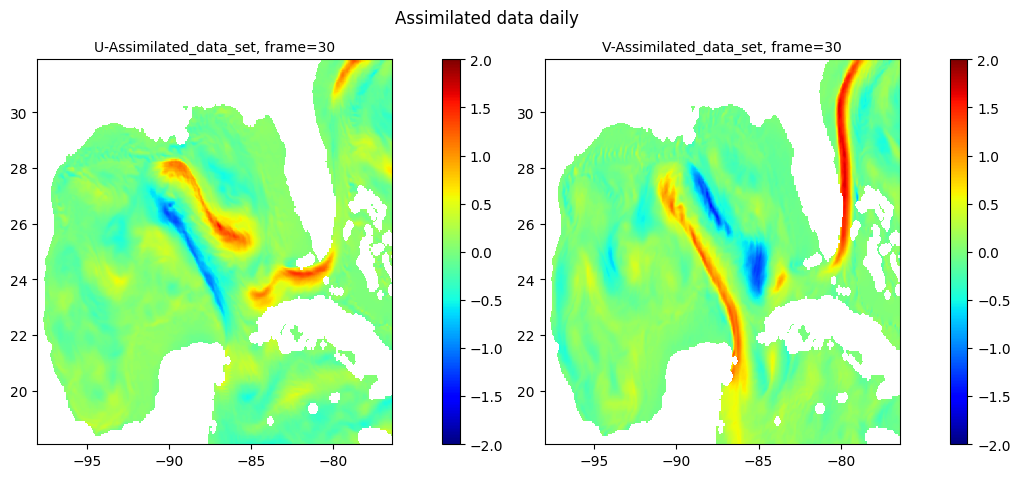

In [31]:
plot_animation(X, Y, Exact_u, Exact_v, n_frames=N_FRAMES, file_name="U_V_Assimilated_data_set", lb=l_b, ub=u_b, title1="U-Assimilated_data_set", title2="V-Assimilated_data_set", suptitle="Assimilated data daily")

## u_true and u_pred animation

In [32]:
X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None] 
v_star = Exact_v.flatten()[:,None]

In [33]:
u_pred, v_pred = model.predict(X_star) 

u_pred_reshaped = u_pred.reshape(X.shape)
v_pred_reshaped = v_pred.reshape(X.shape)

# The following two lines help to add NaN values to the prediction for the case when we use the entire GOM region which also involves ground, i.e., non ocean areas
u_pred_reshaped = ((u_pred_reshaped - Exact_u) + Exact_u)
v_pred_reshaped = ((v_pred_reshaped - Exact_v) + Exact_v)

scipy.io.savemat(data_out_folder+'/DNN_output.mat', {'u_pred':u_pred_reshaped, 'v_pred':v_pred_reshaped})

In [34]:
l_b = -2 # min(Exact_u.min(), u_pred.min())
u_b = 2 #max(Exact_u.max(), u_pred.max())

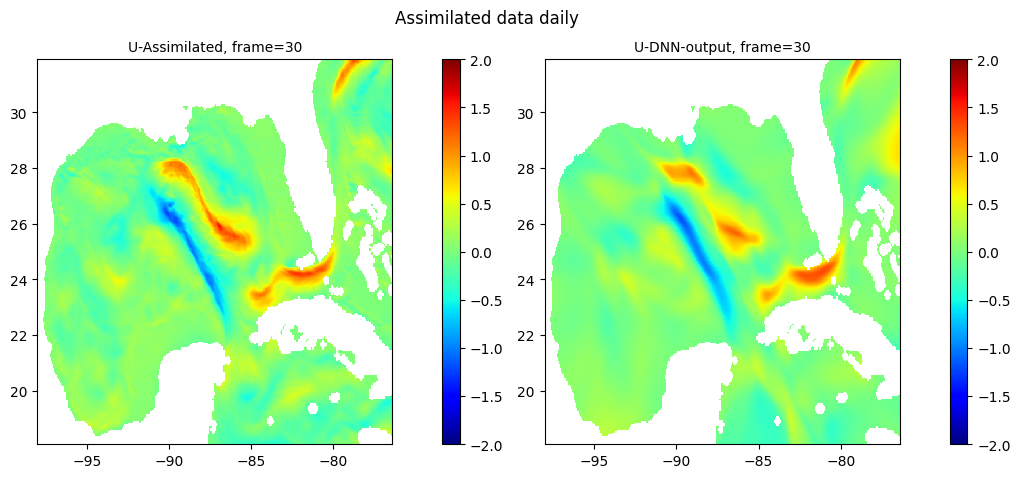

In [35]:
plot_animation(X, Y, Exact_u, u_pred_reshaped, n_frames=N_FRAMES, file_name="U_true_pred_comparison", 
               lb=l_b, ub=u_b, title1="U-Assimilated", title2="U-DNN-output", suptitle="Assimilated data daily")

## v_true and v_pred animation


In [36]:
l_b = -2 # min(np.nanmin(Exact_v), np.nanmin(v_pred))
u_b = 2 # max(np.nanmax(Exact_v), np.nanmax(v_pred))

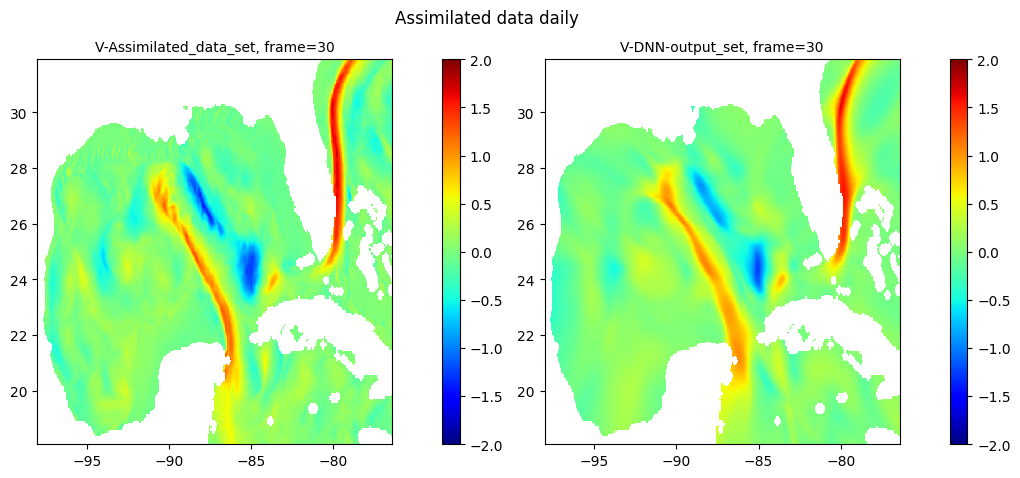

In [37]:
plot_animation(X, Y, Exact_v, v_pred_reshaped, n_frames=N_FRAMES, file_name="V_true_pred_comparison", lb=l_b, ub=u_b, title1="V_True",
               title2="V_Pred", suptitle="Assimilated data - PINN output")

# Point to point difference between true and PINN output

In [38]:
diff_u = Exact_u - u_pred_reshaped
diff_v = Exact_v - v_pred_reshaped

In [39]:
l_b = -2 # min(np.nanmin(Exact_u), np.nanmin(u_pred))
u_b = 2 # max(np.nanmax(Exact_u), np.nanmax(u_pred))

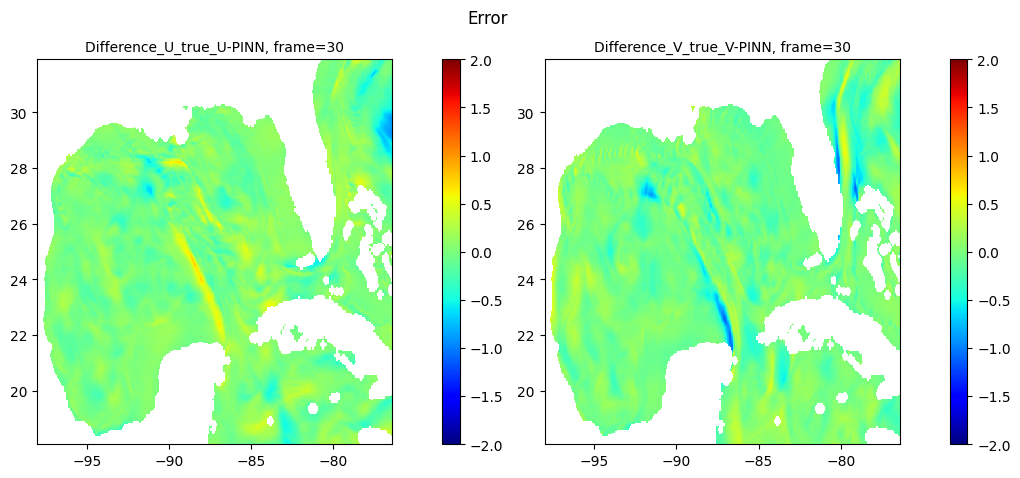

In [40]:
plot_animation(X, Y, diff_u, diff_v, n_frames=N_FRAMES, file_name="UV_true_pred_diff", lb=l_b, ub=u_b, title1="Difference_U_true_U-PINN", title2="Difference_V_true_V-PINN", suptitle="Error")